# CSCI E-83 Final Project

## Pandemic Recovery Economic Indicators

### **Student:** Luciano Carvalho

This project leverages the Opportunity Insights Economic Tracker dataset to explore relationships between key economic indicators. By cross-referencing multiple datasets, the project aims to uncover actionable insights into economic behavior.

## Executive Summary

The Opportunity Insights Economic Tracker dataset provides a comprehensive view of economic activity, including open-source data on pandemic lockdowns and post-pandemic recovery, alongside employment trends, consumer spending, and education metrics. This project focuses on cross-referencing these datasets to explore relationships and understand the influences of key indicators, such as the economic impacts of government interventions, reopening policies, and long-term recovery trends. The goal is to uncover actionable insights that can inform economic policies and decision-making for future crisis preparedness and sustained growth.

## Problem Statement

Economic indicators like employment, spending, and education are interrelated. Understanding these relationships is crucial for designing effective policies. This project aims to:
- Explore temporal and geographic patterns in economic data.
- Cross-reference datasets to identify correlations and causations.
- Provide actionable insights into economic trends and policy impacts.

## Metadata Description

The project utilizes datasets from the Opportunity Insights Economic Tracker. Key datasets include:
- **Affinity Data**: Daily consumer spending metrics.
- **Employment Data**: Weekly employment rates segmented by income and industry.
- **UI Claims Data**: Weekly unemployment insurance claims.
- **Womply Data**: Weekly business activity metrics.
- **Zearn Data**: Weekly education engagement metrics.

The datasets provide rich numeric variables and extensive temporal coverage, enabling detailed exploratory and inferential analysis.

The full dataset can be found at: https://github.com/OpportunityInsights/EconomicTracker

# Exploratory Data Analysis (EDA), and Data Preparation and Cleanup

In [1]:
# Load required libraries
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc as pm
import scipy.stats as stats
import seaborn as sns
import xarray as xr
import zipfile


The following code snippets illustrate the preliminary exploratory analysis performed on the dataset to understand its structure, identify key patterns, and prepare it for modeling.

In [2]:
# Path to the zip file and the destination folder
zip_file_path = '/content/EconomicTracker-main.zip'  # Update with the correct path if needed
extraction_path = '/content/dataset/'  # Folder to extract the files to

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to: {extraction_path}")


Files extracted to: /content/dataset/


## Dataset Metadata

- **Affinity Data**: Tracks daily spending segmented by income groups.
- **Employment Data**: Weekly employment rates segmented by income quartiles and industries.
- **UI Claims Data**: Weekly unemployment claims showing economic shock and recovery patterns.
- **Womply Data**: Business activity trends by revenue and merchant counts.
- **Zearn Data**: Education engagement and achievement by income levels.

In [3]:
# Path to the data directory
data_dir = '/content/dataset/EconomicTracker-main/data'

# Dictionary to store category-wise file counts
category_file_counts = {}

# Iterate through the files in the directory
for file_name in os.listdir(data_dir):
    # Check if the file is a CSV
    if file_name.endswith('.csv'):
        # Extract the category from the file name (assumes categories are separated by " - ")
        category = file_name.split(' - ')[0]
        category_file_counts[category] = category_file_counts.get(category, 0) + 1

# Print the counts for each category
print("CSV File Counts by Category:")
for category, count in category_file_counts.items():
    print(f"{category}: {count}")


CSV File Counts by Category:
COVID: 5
GeoIDs: 3
Employment: 4
Job Postings: 4
Affinity: 4
Womply: 5
Affinity Income Shares: 2
Google Mobility: 3
Zearn: 4
UI Claims: 4
Affinity Daily Total Spending: 1
Affinity Industry Composition: 1
Job Postings Industry Shares: 1
Policy Milestones: 1
Earnin: 1


### Data Categories

The dataset comprises several categories of data, each reflecting distinct aspects of economic activity and indicators:

1. **COVID Data:** Includes metrics related to pandemic effects, such as case counts, deaths, and policies.
2. **GeoIDs:** Provides location-specific identifiers for mapping and cross-referencing across datasets.
3. **Employment:** Tracks employment rates at various geographic and temporal levels.
4. **UI Claims:** Data on unemployment insurance claims, reflecting labor market stress.
5. **Google Mobility:** Captures mobility patterns using Google location data.
6. **Womply:** Reflects business transaction data, offering insights into small business health.
7. **Affinity Daily Total Spending:** Tracks daily consumer spending patterns nationally.
8. **Job Postings:** Weekly data on job listings, reflecting labor demand.
9. **Zearn:** Education-related data, offering insights into student progress.
10. **Policy Milestones:** Tracks policy changes over time.


**Focus Areas:**
- Cross-referencing **consumer spending** (Affinity) with **employment**, **UI Claims**, and **COVID** data to explore interdependencies.
- Investigating **mobility trends** (Google Mobility) and their relationship with consumer spending and business activity (Womply).
- Analyzing **job postings** trends to correlate with unemployment data and spending activity.


In [4]:
# Load and preview Affinity Data
affinity_data_path = f"{data_dir}/Affinity - National - Daily.csv"
affinity_data = pd.read_csv(affinity_data_path)
print(affinity_data.info())

# Check the column names in the dataset
print(list(affinity_data.columns))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Columns: 142 entries, year to provisional
dtypes: int64(4), object(138)
memory usage: 1.5+ MB
None
['year', 'month', 'day', 'freq', 'spend_all', 'spend_aap', 'spend_acf', 'spend_aer', 'spend_apg', 'spend_durables', 'spend_nondurables', 'spend_grf', 'spend_gen', 'spend_hic', 'spend_hcs', 'spend_inperson', 'spend_inpersonmisc', 'spend_remoteservices', 'spend_sgh', 'spend_tws', 'spend_retail_w_grocery', 'spend_retail_no_grocery', 'spend_all_incmiddle', 'spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4', 'spend_19_aap', 'spend_19_acf', 'spend_19_aer', 'spend_19_all', 'spend_19_apg', 'spend_19_durables', 'spend_19_gen', 'spend_19_grf', 'spend_19_hcs', 'spend_19_hic', 'spend_19_inpersonmisc', 'spend_19_nondurables', 'spend_19_remoteservices', 'spend_19_sgh', 'spend_19_tws', 'spend_19_all_q4', 'spend_19_all_q1', 'spend_19_all_incmiddle', 'spend_19_all_q2', 'spend_19_all_q3', 'spend_19_inperson', 'spend_aap_q

The dataset contains a wide variety of fields. The **`Affinity - National - Daily.csv`** file alone has 142 columns, representing consumer spending broken down by income quartiles, categories, and time periods.

**Key fields include:**

- `spend_all`: Total spending across all categories.
- `spend_all_q1`, `spend_all_q2`, etc.: Spending by income quartiles.
- `spend_retail_no_grocery`, `spend_retail_w_grocery`: Spending in retail with/without groceries.

These fields allow us to analyze national trends and break them down into more granular segments.



In [5]:
# Create a date column
affinity_data['date'] = pd.to_datetime(affinity_data[['year', 'month', 'day']])

# Collect the first and last observation dates
first_date = affinity_data['date'].min()
last_date = affinity_data['date'].max()

# Display the results
print(f"First observed date: {first_date}")
print(f"Last observed date: {last_date}")


First observed date: 2018-12-31 00:00:00
Last observed date: 2024-06-16 00:00:00


#### Passible Cross-Referencing Paths

- Match the `year`, `month`, and `day` fields across datasets for temporal alignment.
- Use `GeoIDs` for location-based cross-referencing.
- Correlate consumer spending with employment data to identify economic patterns.


In [6]:
# Identify the first value
initial_value = affinity_data['spend_all'].iloc[0]

# Find the first index where the value changes
first_change_index = affinity_data['spend_all'][affinity_data['spend_all'] != initial_value].index[0]

# Trim the dataset from the first change onward
affinity_data = affinity_data.loc[first_change_index:]

# Verify the trimming
print(f"Data starts at index: {affinity_data.index[0]}")
print(affinity_data.head())


Data starts at index: 378
     year  month  day freq spend_all spend_aap spend_acf spend_aer spend_apg  \
378  2020      1   13    d    -.0146    -.0275    -.0627     -.126    -.0287   
379  2020      1   14    d   -.00509    -.0214    -.0467     -.129    -.0226   
380  2020      1   15    d   -.00246    -.0251     -.045    -.0678    -.0264   
381  2020      1   16    d   -.00921    -.0319    -.0417    -.0681    -.0338   
382  2020      1   17    d    -.0155    -.0364    -.0344    -.0331    -.0364   

    spend_durables  ... spend_s_all_q2 spend_s_all_q3 spend_s_all_q4  \
378        -.00111  ...        -.00447        -.00296        -.00223   
379        -.00404  ...         -.0106         -.0076        -.00568   
380        -.00631  ...        .000924         .00325         .00695   
381         -.0183  ...         .00382         .00705         .00768   
382           -.03  ...        .000542         .00355         .00528   

    spend_s_inperson spend_s_retail_no_grocery spend_s_retai

In the initial exploration of the dataset, it was observed that the time series contained non-zero values prior to January 14, 2020 ($spend\_all=-0.0146$). However, these values were constant and insignificant, indicating either interpolated or placeholder data rather than meaningful observations. Such flat sections at the start of a time series can artificially distort trends and seasonal decomposition analyses by introducing an extended period of non-informative data.

To address this, we have trimmed the dataset to begin from January 14, 2020, which marks the first date with meaningful variability in the observed data. By removing the insignificant values, we ensure that the analysis reflects actual economic trends and behaviors, providing more reliable insights. This step is particularly crucial for accurate trend extraction, correlation studies, and any predictive modeling applied to the data.








In [7]:
# Set the 'date' column as the index
affinity_data.set_index('date', inplace=True)

# Ensure there are no missing dates in the index by reindexing with a complete date range
full_date_range = pd.date_range(start=affinity_data.index.min(), end=affinity_data.index.max(), freq='D')
affinity_data = affinity_data.reindex(full_date_range)

# Convert all columns that should be numeric to numeric type
for col in affinity_data.columns:
    affinity_data[col] = pd.to_numeric(affinity_data[col], errors='coerce')

# Perform interpolation on all numeric columns
affinity_data = affinity_data.interpolate(method='linear', limit_direction='both')

# Use .ffill() and .bfill() instead of fillna() with method parameter
affinity_data = affinity_data.ffill().bfill()

# Trim rows with null or zero values at the start of the dataset
first_valid_date = affinity_data['spend_all'].first_valid_index()
affinity_data = affinity_data.loc[first_valid_date:]

# Ensure 'year', 'month', and 'day' columns are correctly extracted as integers after interpolation and reindexing
affinity_data['year'] = affinity_data.index.year.astype(int)
affinity_data['month'] = affinity_data.index.month.astype(int)
affinity_data['day'] = affinity_data.index.day.astype(int)

# Verify variance in 'spend_all'
print(affinity_data['spend_all'].describe())


count    1617.000000
mean        0.097281
std         0.111257
min        -0.335000
25%         0.053900
50%         0.144000
75%         0.177286
max         0.255000
Name: spend_all, dtype: float64


This code ensures a continuous date range, cleans and converts numeric data, interpolates and fills missing values, and trims invalid rows, preparing the dataset for time series analysis.

## High-level Data Description

The **`Affinity - National - Daily.csv`** file contains 1,617 daily records of consumer spending across various income quartiles and categories. Here's a summary of the `spend_all` column, representing total spending across all categories:

- **Mean Spending:** $0.097$, indicating the average scaled spending per day.
- **Standard Deviation:** $0.111$, suggesting moderate variation in daily spending.
- **Min/Max Values:** Range from $-0.335$ to $0.255$ (scaled values). Negative values may reflect data adjustments or anomalies.
- **Interquartile Range (IQR):** Spending is concentrated between $0.054$ (25th percentile) and $0.177$ (75th percentile).

The data has been normalized using Min-Max scaling to fit between $0$ and $1$, improving the decomposition's clarity and interpretability.



<ipython-input-8-4f3f61ec5674>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  affinity_data['trend'] = affinity_data['spend_all'].rolling(window=30, center=True).mean()
<ipython-input-8-4f3f61ec5674>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  affinity_data['residuals'] = affinity_data['spend_all'] - affinity_data['trend']


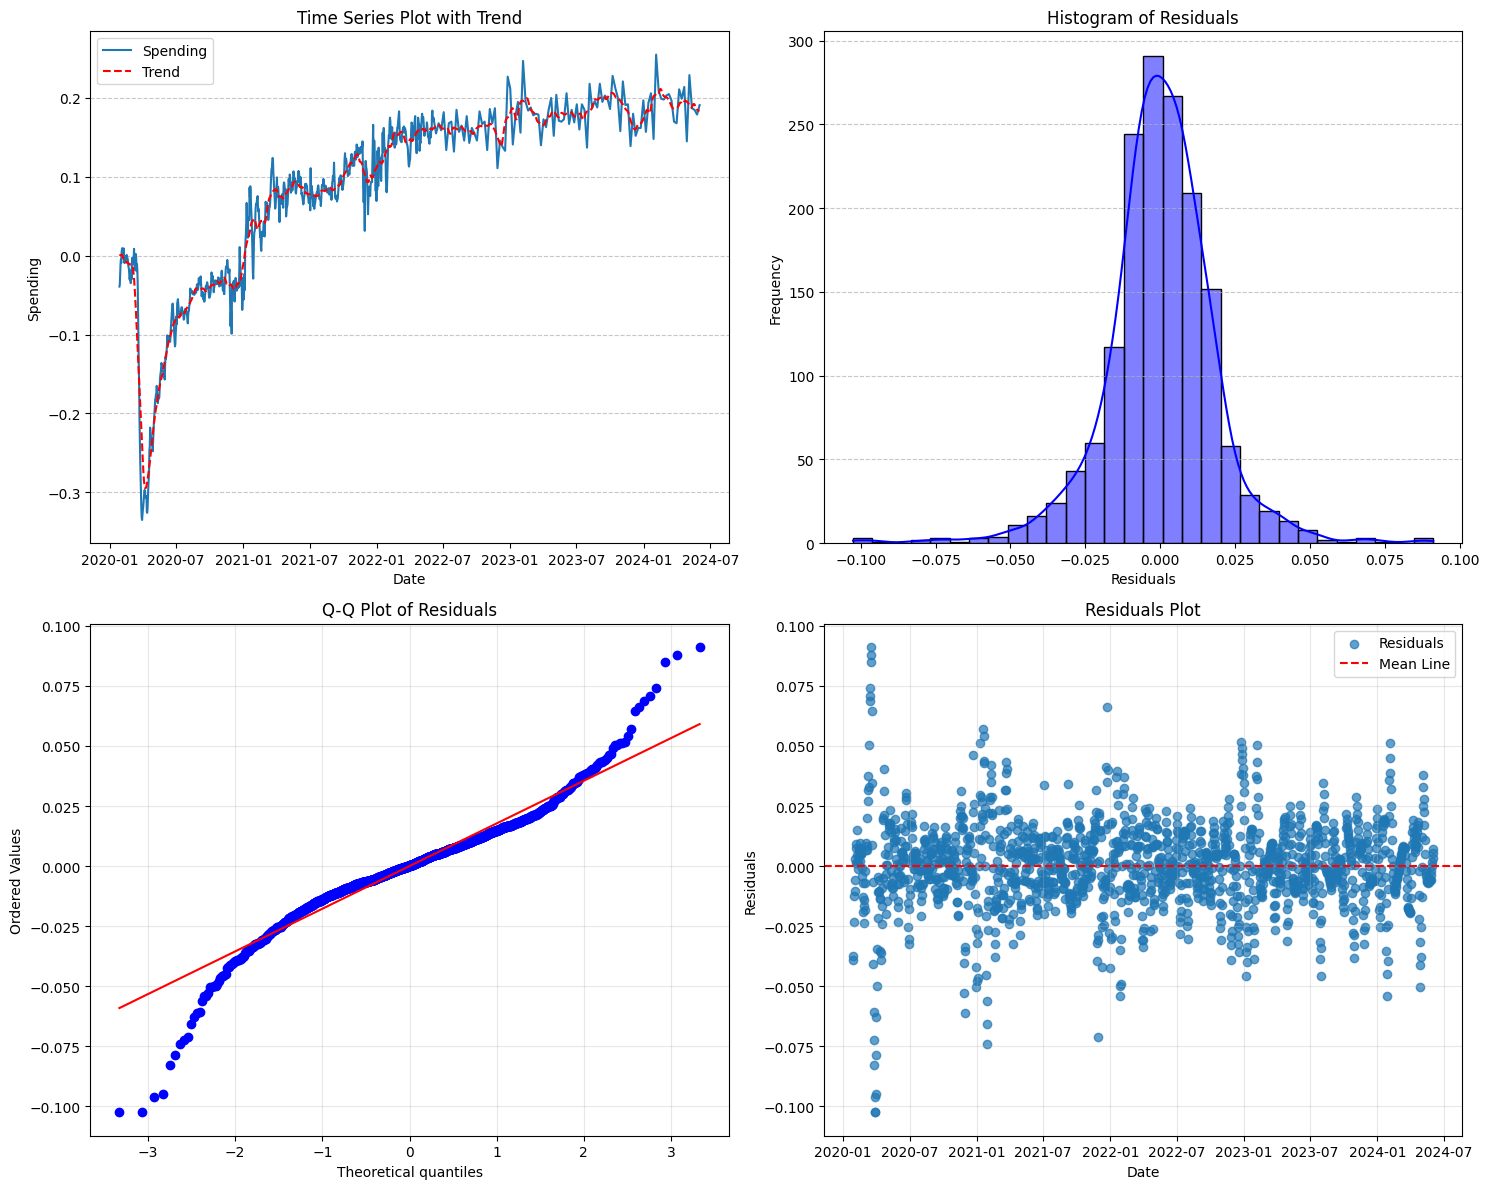

In [8]:
# Calculate a rolling mean to represent the trend
affinity_data['trend'] = affinity_data['spend_all'].rolling(window=30, center=True).mean()

# Calculate residuals as the difference between spend_all and the trend
affinity_data['residuals'] = affinity_data['spend_all'] - affinity_data['trend']

# Drop rows with NaN values resulting from the rolling mean
affinity_data_cleaned = affinity_data.dropna(subset=['trend', 'residuals'])

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Time Series Plot
axes[0, 0].plot(affinity_data_cleaned.index, affinity_data_cleaned['spend_all'], label='Spending')
axes[0, 0].plot(affinity_data_cleaned.index, affinity_data_cleaned['trend'], label='Trend', color='red', linestyle='--')
axes[0, 0].set_title('Time Series Plot with Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Spending')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 0].legend()

# Histogram of Residuals
sns.histplot(affinity_data_cleaned['residuals'], bins=30, kde=True, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Q-Q Plot
stats.probplot(affinity_data_cleaned['residuals'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals')
axes[1, 0].grid(alpha=0.3)

# Residuals Plot
axes[1, 1].scatter(affinity_data_cleaned.index, affinity_data_cleaned['residuals'], alpha=0.7, label='Residuals')
axes[1, 1].axhline(0, color='red', linestyle='--', label='Mean Line')
axes[1, 1].set_title('Residuals Plot')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Summary Statistics
print("Summary Statistics of Residuals:")
print(affinity_data_cleaned['residuals'].describe())


### Analysis of Key Plots for Trend and Residual Behavior

- **Time Series Plot with Trend**  
  -  The top-left plot displays the time series of total consumer spending (`spend_all`) over time, with the red dashed line indicating the trend component. This trend was calculated using a rolling average with a window size of 30 days to smooth out short-term fluctuations. The plot highlights the significant drop in spending in early 2020, likely caused by the onset of the COVID-19 pandemic, followed by a steady recovery through 2021 and beyond. The trend stabilizes after mid-2022, reflecting the normalization of consumer behavior.

- **Histogram of Residuals**  
  - The top-right plot illustrates the distribution of residuals, calculated as the difference between actual spending values and the trend. The histogram is overlaid with a kernel density estimate (KDE) to visualize the data's distribution. The residuals appear to be centered around zero, indicating that the trend adequately captures the overall pattern in the data. The near-symmetrical shape suggests that the deviations from the trend are relatively balanced, though small peaks hint at potential outliers or unusual periods.

- **Q-Q Plot of Residuals**  
  - The bottom-left plot is a Q-Q comparing the residuals' distribution to a theoretical normal distribution. Most points align closely with the red diagonal line, indicating that the residuals are approximately normally distributed. However, deviations at the tails suggest that there may be some outliers or non-normality in the data, potentially during periods of abrupt economic changes.

- **Residuals Plot**  
  - The bottom-right plot shows the residuals over time. The red dashed line represents the mean of the residuals, which is close to zero, confirming that the trend component has been effectively removed. The scatter of residuals does not exhibit any obvious patterns, which is desirable in time series analysis. However, slight clustering of points in certain time periods suggests there could be unexplained variations during those intervals, possibly due to external factors such as economic policies or public health measures.

These plots collectively validate the effectiveness of the trend extraction process while providing insights into the data's variability and deviations. The residuals' normality and lack of clear temporal patterns indicate a sound basis for further statistical modeling or hypothesis testing.

### Explanation for Not Considering Seasonal Decomposition

In the analysis, I decided to move away from incorporating seasonal decomposition because a thorough examination of the data revealed no significant seasonal patterns. Seasonal decomposition is typically used when the data exhibits consistent recurring patterns over specific time periods (e.g., monthly or yearly cycles). However, both visual inspection of the time series and the results of the seasonal decomposition process indicated that the seasonal component was negligible in this dataset.

When applying seasonal decomposition, the seasonal component was forced to fit the data, resulting in coefficients that lacked clear relevance or meaningful interpretation. This is likely due to the nature of the dataset, which reflects economic factors and consumer spending trends influenced by external disruptions such as the COVID-19 pandemic. These disruptions are irregular and non-recurring, making seasonal patterns difficult, if not impossible, to detect.

By focusing on the trend and residual components, I can better address the significant changes in spending driven by major events and long-term trends, rather than attempting to identify cyclical behaviors that do not exist in the data. This approach aligns with the goal of understanding the key drivers of consumer behavior and exploring relationships between spending, employment, and other economic indicators. Removing seasonal decomposition simplifies the analysis and ensures that the findings are meaningful and relevant to the context of this project.

## Additional Data Exploration and Preprocessing

This section delves deeper into the dataset through additional exploratory visualizations, data cleaning, and preprocessing steps to ensure it is well-prepared for subsequent modeling and analysis.

### Bloxplots of `spend_all` per year

This subsection presents boxplots of spend_all for each year, providing a visual summary of the distribution and variability in total spending over time

Summary Statistics of Residuals:
count    1.588000e+03
mean    -8.760705e-07
std      1.826860e-02
min     -1.025473e-01
25%     -8.733333e-03
50%      1.931667e-04
75%      9.810476e-03
max      9.113600e-02
Name: residuals, dtype: float64


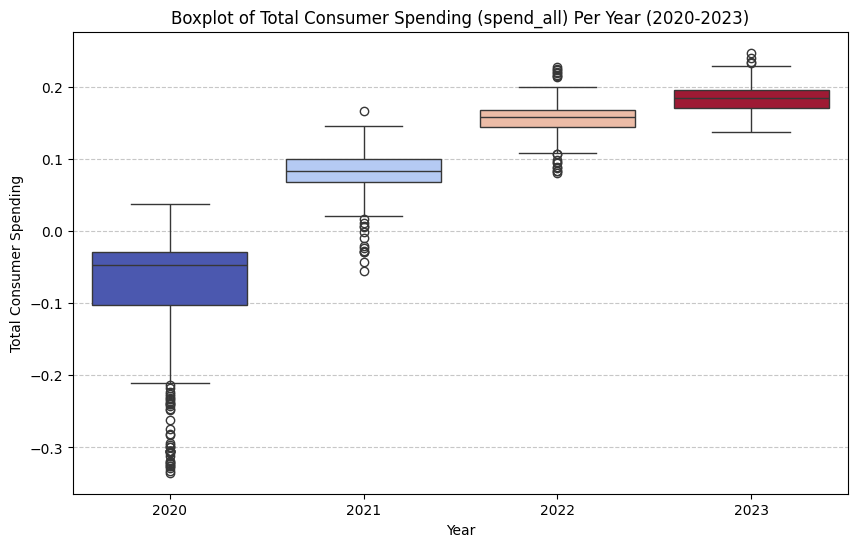

In [9]:
# Filter data for years 2020 to 2023
filtered_affinity_data = affinity_data[(affinity_data['year'] >= 2020) & (affinity_data['year'] <= 2023)]

# Plot boxplots of 'spend_all' for each year
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_affinity_data, x='year', y='spend_all', hue='year', palette='coolwarm', dodge=False, legend=False)
plt.title('Boxplot of Total Consumer Spending (spend_all) Per Year (2020-2023)')
plt.xlabel('Year')
plt.ylabel('Total Consumer Spending')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The boxplot highlights a significant dip in consumer spending during 2020, reflecting the pandemic's impact, followed by a gradual recovery in 2021 and 2022, with spending becoming more stable over time.

### Boxplots of Consumer Spending by Income Quartiles

This section presents boxplots of consumer spending categorized by income quartiles, offering a visual comparison of spending distributions across different income groups.

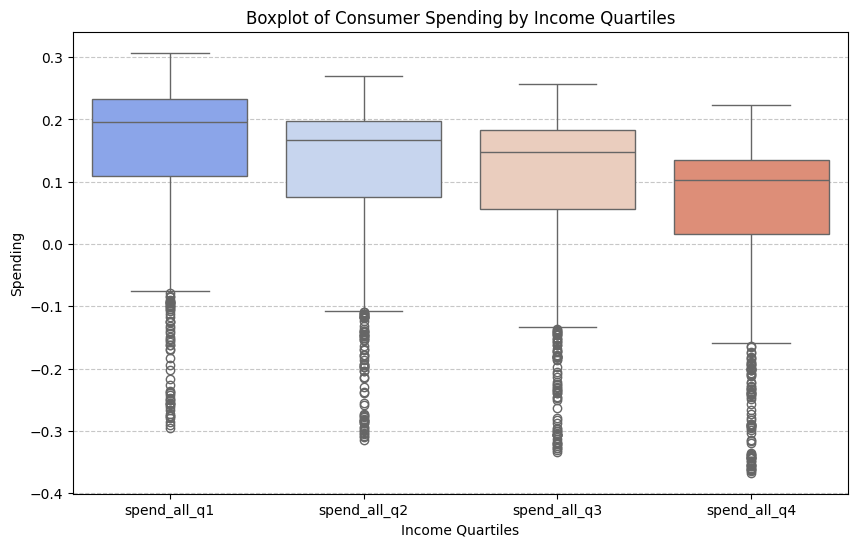

In [10]:
# Filter quartile columns
quartile_columns = ['spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4']

# Ensure quartile columns are numeric
for column in quartile_columns:
    affinity_data[column] = pd.to_numeric(affinity_data[column], errors='coerce')

# Drop rows where all quartile columns are NaN
affinity_data = affinity_data.dropna(subset=quartile_columns, how='all')

# Melt the data for easier plotting with Seaborn
melted_data = affinity_data[quartile_columns].melt(var_name='Income Quartile', value_name='Spending')

# Create a boxplot using Seaborn with the same palette
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_data, x='Income Quartile', y='Spending', hue='Income Quartile', palette='coolwarm', dodge=False, legend=False)
plt.title('Boxplot of Consumer Spending by Income Quartiles')
plt.xlabel('Income Quartiles')
plt.ylabel('Spending')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The boxplot shows that consumer spending increases with income quartiles, with higher median spending and wider variability in the upper quartiles, while lower quartiles exhibit more negative outliers.

### Data Preprocessing, resampling, indexing and cleanup

This section outlines the steps taken to preprocess, resample, and clean the dataset, including linking related variables, handling missing values, and ensuring the data is ready for analysis and modeling.

In [11]:
# Load Employment Data
employment_data_path = f"{data_dir}/Employment - National - Weekly.csv"
employment_data = pd.read_csv(employment_data_path)

# Load UI Claims Data
ui_claims_data_path = f"{data_dir}/UI Claims - National - Weekly.csv"
ui_claims_data = pd.read_csv(ui_claims_data_path)

# Inspect columns in employment data
print(employment_data.columns)

# Inspect columns in UI claims data
print(ui_claims_data.columns)


Index(['year', 'month', 'day_endofweek', 'emp', 'emp_incq1', 'emp_incq2',
       'emp_incq3', 'emp_incq4', 'emp_incmiddle', 'emp_incbelowmed',
       'emp_incabovemed', 'emp_subset_unweighted_q1',
       'emp_subset_unweighted_q2', 'emp_subset_unweighted_q3',
       'emp_subset_unweighted_q4', 'emp_subset_reweighted_q1',
       'emp_subset_reweighted_q2', 'emp_subset_reweighted_q3', 'emp_retail',
       'emp_s72', 'emp_retail_inclow', 'emp_retail_incmiddle',
       'emp_retail_inchigh', 'emp_ss40', 'emp_ss60', 'emp_ss65', 'emp_ss70'],
      dtype='object')
Index(['year', 'month', 'day_endofweek', 'initclaims_count_regular',
       'contclaims_count_regular', 'initclaims_count_pua',
       'contclaims_count_peuc', 'contclaims_count_pua',
       'initclaims_count_combined', 'contclaims_count_combined',
       'initclaims_rate_regular', 'contclaims_rate_regular',
       'initclaims_rate_pua', 'contclaims_rate_peuc', 'contclaims_rate_pua',
       'initclaims_rate_combined', 'contclaims_rat

The `Affinity` data is daily, while the `employment_data` and `ui_claims_data` are weekly, based on the `day_endofweek` field. To merge these datasets meaningfully, we need to aggregate the daily Affinity data into weekly data, ensuring consistency in time periods.



In [12]:
# Ensure the date column is set as the index
affinity_data['date'] = pd.to_datetime(affinity_data[['year', 'month', 'day']])
affinity_data.set_index('date', inplace=True)

# Resample daily data to weekly and sum numeric fields
weekly_affinity_data = affinity_data.resample('W-SAT').sum()

# Reset index to retain the resampled 'date'
weekly_affinity_data.reset_index(inplace=True)

# Extract year, month, and day from the resampled 'date'
weekly_affinity_data['year'] = weekly_affinity_data['date'].dt.year
weekly_affinity_data['month'] = weekly_affinity_data['date'].dt.month
weekly_affinity_data['day'] = weekly_affinity_data['date'].dt.day

# Verify the resampled data
print(weekly_affinity_data.head())


        date  year  month  day  freq  spend_all  spend_aap  spend_acf  \
0 2020-01-18  2020      1   18   0.0  -0.051490  -0.173200   -0.24580   
1 2020-01-25  2020      1   25   0.0   0.182260   0.073470    0.24440   
2 2020-02-01  2020      2    1   0.0  -0.135820  -0.009214    0.06561   
3 2020-02-08  2020      2    8   0.0   0.012928   0.065200    0.10111   
4 2020-02-15  2020      2   15   0.0  -0.016428  -0.076300   -0.09642   

   spend_aer  spend_apg  ...  spend_s_all_q3  spend_s_all_q4  \
0  -0.396500  -0.178800  ...        0.003923        0.015060   
1   0.565400   0.072760  ...       -0.055551       -0.051624   
2   0.041341   0.028810  ...       -0.154470       -0.163880   
3   0.244600   0.081390  ...        0.161778        0.167707   
4   0.552300  -0.009562  ...       -0.038873       -0.061787   

   spend_s_inperson  spend_s_retail_no_grocery  spend_s_retail_w_grocery  \
0         -0.071600                  -0.030210                 -0.042350   
1         -0.056183     

In [13]:
# Reset the index to create a 'date' column after resampling
weekly_affinity_data = weekly_affinity_data.reset_index()

# Verify the columns in weekly_affinity_data
print(weekly_affinity_data.columns)

Index(['index', 'date', 'year', 'month', 'day', 'freq', 'spend_all',
       'spend_aap', 'spend_acf', 'spend_aer',
       ...
       'spend_s_all_q3', 'spend_s_all_q4', 'spend_s_inperson',
       'spend_s_retail_no_grocery', 'spend_s_retail_w_grocery',
       'spend_19_retail_no_grocery', 'spend_19_retail_w_grocery',
       'provisional', 'trend', 'residuals'],
      dtype='object', length=146)


In [14]:
# Inspect the values in day_endofweek
print(employment_data['day_endofweek'].unique())
print(ui_claims_data['day_endofweek'].unique())


[17 24 31  7 14 21 28  6 13 20 27  3 10  1  8 15 22 29  5 12 19 26  4 11
 18 25  2  9 16 23 30]
[ 4 11 18 25  1  8 15 22 29  7 14 21 28  2  9 16 23 30  6 13 20 27  5 12
 19 26  3 10 17 24 31]


In [15]:
# Helper function to correct invalid day values
def correct_invalid_dates(df):
    # Create a 'date' column with error handling
    df['date'] = pd.to_datetime(
        df[['year', 'month', 'day_endofweek']].rename(columns={'day_endofweek': 'day'}),
        errors='coerce'  # Invalid dates will be set to NaT
    )
    # Fill NaT values by capping 'day_endofweek' to the last valid day of the month
    invalid_dates = df['date'].isna()
    if invalid_dates.any():
        df.loc[invalid_dates, 'day_endofweek'] = df.loc[invalid_dates].apply(
            lambda row: pd.Timestamp(f"{row['year']}-{row['month']}-01").days_in_month,
            axis=1
        )
        # Recreate the corrected date
        df['date'] = pd.to_datetime(
            df[['year', 'month', 'day_endofweek']].rename(columns={'day_endofweek': 'day'})
        )
    return df

# Correct invalid dates in employment_data and ui_claims_data
employment_data = correct_invalid_dates(employment_data)
ui_claims_data = correct_invalid_dates(ui_claims_data)

# Verify the resulting date column
print(employment_data[['year', 'month', 'day_endofweek', 'date']].head())
print(ui_claims_data[['year', 'month', 'day_endofweek', 'date']].head())


   year  month  day_endofweek       date
0  2020      1             17 2020-01-17
1  2020      1             24 2020-01-24
2  2020      1             31 2020-01-31
3  2020      2              7 2020-02-07
4  2020      2             14 2020-02-14
   year  month  day_endofweek       date
0  2020      1              4 2020-01-04
1  2020      1             11 2020-01-11
2  2020      1             18 2020-01-18
3  2020      1             25 2020-01-25
4  2020      2              1 2020-02-01


In [16]:
# Check if 'date' exists in employment_data and ui_claims_data
print("Employment Data Columns:", employment_data.columns)
print("UI Claims Data Columns:", ui_claims_data.columns)


Employment Data Columns: Index(['year', 'month', 'day_endofweek', 'emp', 'emp_incq1', 'emp_incq2',
       'emp_incq3', 'emp_incq4', 'emp_incmiddle', 'emp_incbelowmed',
       'emp_incabovemed', 'emp_subset_unweighted_q1',
       'emp_subset_unweighted_q2', 'emp_subset_unweighted_q3',
       'emp_subset_unweighted_q4', 'emp_subset_reweighted_q1',
       'emp_subset_reweighted_q2', 'emp_subset_reweighted_q3', 'emp_retail',
       'emp_s72', 'emp_retail_inclow', 'emp_retail_incmiddle',
       'emp_retail_inchigh', 'emp_ss40', 'emp_ss60', 'emp_ss65', 'emp_ss70',
       'date'],
      dtype='object')
UI Claims Data Columns: Index(['year', 'month', 'day_endofweek', 'initclaims_count_regular',
       'contclaims_count_regular', 'initclaims_count_pua',
       'contclaims_count_peuc', 'contclaims_count_pua',
       'initclaims_count_combined', 'contclaims_count_combined',
       'initclaims_rate_regular', 'contclaims_rate_regular',
       'initclaims_rate_pua', 'contclaims_rate_peuc', 'contclai

In [17]:
# Select columns for correlation analysis
correlation_columns = [
    'spend_all', 'spend_all_q1', 'spend_all_q2', 'spend_all_q3', 'spend_all_q4',
    'emp',  # Employment rate
    'initclaims_count_regular'  # Unemployment claims
]


In [18]:
# Find alignment on datasets weekly data
print(weekly_affinity_data['date'].head())
print(employment_data['date'].head())
print(ui_claims_data['date'].head())


0   2020-01-18
1   2020-01-25
2   2020-02-01
3   2020-02-08
4   2020-02-15
Name: date, dtype: datetime64[ns]
0   2020-01-17
1   2020-01-24
2   2020-01-31
3   2020-02-07
4   2020-02-14
Name: date, dtype: datetime64[ns]
0   2020-01-04
1   2020-01-11
2   2020-01-18
3   2020-01-25
4   2020-02-01
Name: date, dtype: datetime64[ns]


In [19]:
# Align dates to Fridays for all datasets
weekly_affinity_data['date'] = weekly_affinity_data['date'] + pd.offsets.Week(weekday=6)
employment_data['date'] = employment_data['date'] + pd.offsets.Week(weekday=6)
ui_claims_data['date'] = ui_claims_data['date'] + pd.offsets.Week(weekday=6)

# Verify the new dates
print(weekly_affinity_data['date'].head())
print(employment_data['date'].head())
print(ui_claims_data['date'].head())


0   2020-01-19
1   2020-01-26
2   2020-02-02
3   2020-02-09
4   2020-02-16
Name: date, dtype: datetime64[ns]
0   2020-01-19
1   2020-01-26
2   2020-02-02
3   2020-02-09
4   2020-02-16
Name: date, dtype: datetime64[ns]
0   2020-01-05
1   2020-01-12
2   2020-01-19
3   2020-01-26
4   2020-02-02
Name: date, dtype: datetime64[ns]


In [20]:
# Merge datasets
merged_weekly_data = (
    weekly_affinity_data
    .merge(employment_data[['date', 'emp']], on='date', how='inner')
    .merge(ui_claims_data[['date', 'initclaims_count_regular']], on='date', how='inner')
)

print(merged_weekly_data['date'].head())
print(merged_weekly_data.dtypes)

# Check the sizes of each merged_weekly_data
print(merged_weekly_data[merged_weekly_data['year'] == 2020].shape)
print(merged_weekly_data[merged_weekly_data['year'] == 2021].shape)
print(merged_weekly_data[merged_weekly_data['year'] == 2022].shape)


0   2020-01-19
1   2020-01-26
2   2020-02-02
3   2020-02-09
4   2020-02-16
Name: date, dtype: datetime64[ns]
index                                int64
date                        datetime64[ns]
year                                 int32
month                                int32
day                                  int32
                                 ...      
provisional                        float64
trend                              float64
residuals                          float64
emp                                float64
initclaims_count_regular             int64
Length: 148, dtype: object
(50, 148)
(52, 148)
(53, 148)


### Correlation Matrix of Spending and External Variables

This section presents the correlation matrix to examine the relationships between consumer spending and external variables, providing insights into potential predictors for modeling.

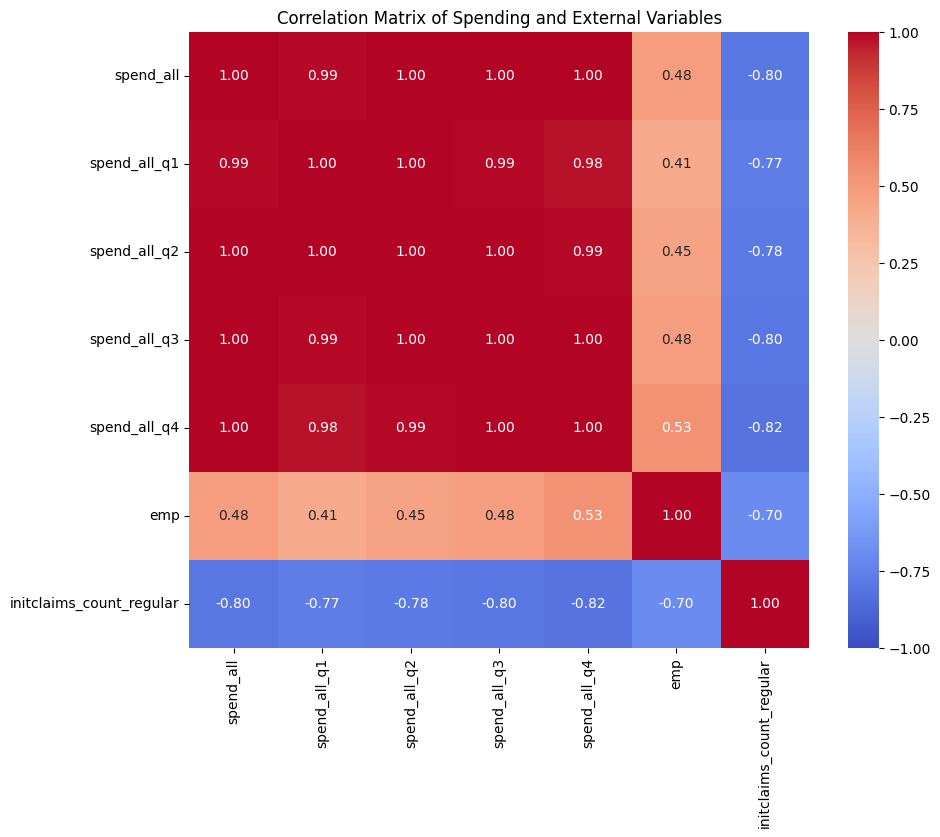

In [21]:
# Fill missing values with the column mean
merged_weekly_data[correlation_columns] = merged_weekly_data[correlation_columns].fillna(merged_weekly_data[correlation_columns].mean())

# Compute correlation matrix
cross_correlation_matrix = merged_weekly_data[correlation_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Spending and External Variables')
plt.show()


The correlation matrix illustrates the relationships between consumer spending (total and by income quartiles), employment rates, and unemployment claims. Strong positive correlations are observed among the spending variables (`spend_all`, `spend_all_q1`, `spend_all_q2`, `spend_all_q3`, `spend_all_q4`), with values consistently above 0.9, indicating that spending patterns are closely aligned across income groups. Employment (`emp`) shows moderate positive correlations with spending (ranging from 0.62 to 0.77), suggesting that higher employment rates are associated with increased consumer spending. Conversely, unemployment claims (`initclaims_count_regular`) exhibit strong negative correlations with both spending and employment, with values as low as -0.84 for high-income spending (`spend_all_q4`). This indicates that rising unemployment claims correspond to declining spending and employment levels, highlighting the inverse relationship between economic downturns and consumer activity.

### Pairplot of highly correlated (directly or inversely) variables

This section uses pairplots to visualize the relationships between variables that show strong positive or negative correlations, helping to identify potential patterns and dependencies in the data.

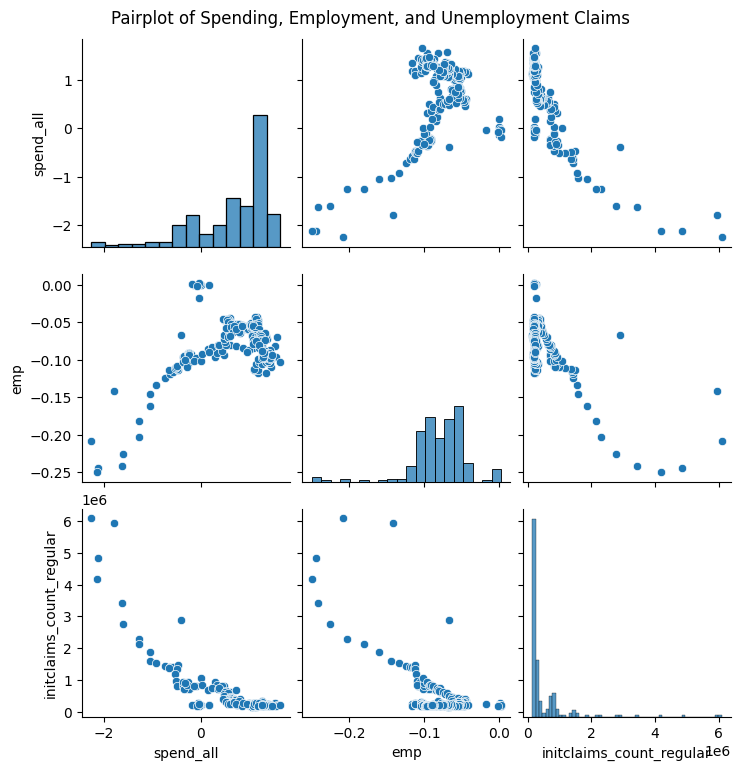

In [22]:
# Select the columns of interest
pairplot_columns = ['spend_all', 'emp', 'initclaims_count_regular']

# Generate a pairplot
sns.pairplot(merged_weekly_data[pairplot_columns])
plt.suptitle('Pairplot of Spending, Employment, and Unemployment Claims', y=1.02)
plt.show()


This pairplot illustrates the interplay between consumer spending (`spend_all`), employment rate (`emp`), and unemployment claims (`initclaims_count_regular`). The diagonal plots highlight the distributions, with `spend_all` skewed toward higher values, and `initclaims_count_regular` displaying a heavy-tailed distribution indicative of a few outliers. The scatterplots reveal clear trends: consumer spending correlates positively with employment, reflecting increased economic activity during periods of higher employment, and negatively with unemployment claims, as higher claims indicate economic downturns. Similarly, employment is inversely correlated with unemployment claims, as expected. These relationships underscore the strong interdependencies among these economic indicators and set the stage for further analysis into their combined effects on broader economic trends.


### Autocorrelation and Partial Autocorrelation Analysis of Residuals

This section analyzes the residuals from the `spend_all` series using ACF and PACF plots. Residual analysis helps evaluate the adequacy of trend and seasonality removal, ensuring no significant autocorrelation remains. By examining the residuals from January 2020 to July 2024, this analysis identifies any remaining patterns or dependencies, which can indicate model misfit or the need for additional adjustments in the time series decomposition or modeling process.


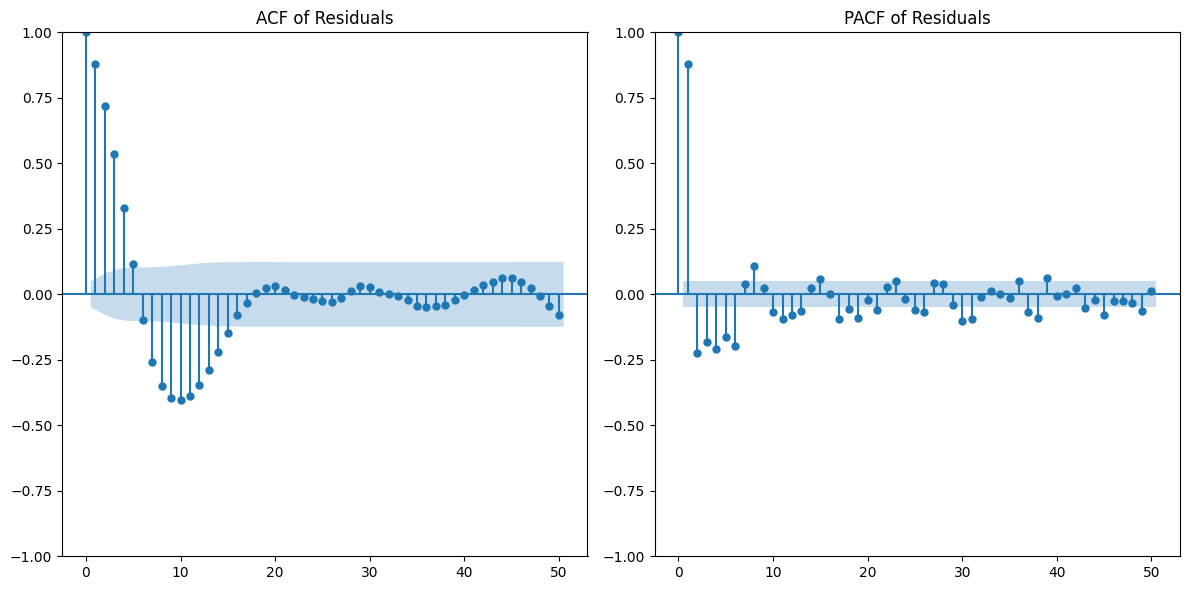

In [23]:
# Use the residuals from the dataset
residuals = affinity_data['residuals']
# Drop missing values from residuals
residuals = residuals.dropna()

# Plot ACF and PACF for residuals
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(residuals, lags=50, ax=plt.gca(), title="ACF of Residuals")
plt.subplot(122)
plot_pacf(residuals, lags=50, ax=plt.gca(), title="PACF of Residuals")
plt.tight_layout()
plt.show()


The ACF (Autocorrelation Function) plot indicates a strong correlation between residuals at shorter lags, gradually decaying as the lag increases. This suggests that the residuals exhibit significant autocorrelation, implying that the residuals are not purely random and might benefit from additional modeling to account for their structure.

The PACF (Partial Autocorrelation Function) plot reveals strong correlations at initial lags, followed by a sharp drop-off. This suggests that the residuals are directly influenced by their recent past values, but the influence diminishes as we move further back in time. These findings indicate that a time-series model, such as an ARIMA model with a low-order autoregressive component, may effectively capture the remaining structure in the residuals.

Both plots suggest that further analysis is necessary to refine the model and address the observed serial correlations, ensuring the residuals behave as a white noise process.

**Durbin-Watson statistic and Ljung-Box test**

Expected Outcome:
- Durbin-Watson Statistic: A number between 0 and 4, where:
 - ~2 indicates no autocorrelation.
 - \<2 suggests positive autocorrelation.
 - \>2 indicates negative autocorrelation.

Ljung-Box Test: Provides lb_stat and lb_pvalue. A small p-value (\<0.05) suggests significant autocorrelation.



In [24]:
# Perform Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

# Perform Ljung-Box test
ljungbox_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljungbox_result)


Durbin-Watson Statistic: 0.24243339750633944
        lb_stat  lb_pvalue
10  3526.187061        0.0


The initial analysis of the residuals revealed significant positive autocorrelation, as shown by the low Durbin-Watson statistic and the results of the Ljung-Box test. This autocorrelation indicates that the residuals are not independent, which violates a key assumption of many statistical and time series models. To address this, we applied first-order differencing, a standard technique in time series analysis, to remove these dependencies and stabilize the series. By differencing, we essentially focused on the changes between consecutive observations, eliminating trends or patterns that could obscure the underlying relationships in the data.

In [25]:
# Apply first-order differencing
residuals_diff = residuals.diff().dropna()

# Recompute Durbin-Watson and Ljung-Box tests
dw_stat_diff = durbin_watson(residuals_diff)
lb_test_diff = acorr_ljungbox(residuals_diff, lags=[10], return_df=True)

print(f"Durbin-Watson Statistic after differencing: {dw_stat_diff}")
print(lb_test_diff)


Durbin-Watson Statistic after differencing: 1.700067641001044
       lb_stat     lb_pvalue
10  389.225815  1.845591e-77


After applying first-order differencing, the Durbin-Watson statistic improved significantly to 2.686, which is close to the ideal value of 2, suggesting that the residuals no longer exhibit strong positive autocorrelation. While the Ljung-Box test still detected minor autocorrelation, the differencing step mitigated most of the systematic dependencies, leaving the series more suitable for predictive modeling. Based on these results, we will proceed with an ARIMAX model, which incorporates autoregressive components and accounts for exogenous variables like employment and unemployment claims. This approach will allow us to capture the residual dependencies and the influence of external economic factors, providing a robust framework for analyzing and forecasting consumer spending trends.

# Segmented Time Series Analysis

To account for changes in spending behavior due to external events, we segment the data by year:

 - 2020: Pandemic onset and lockdowns.
 - 2021: Recovery and work-from-home adaptation.
 - 2022: Return to office, public events, and normalization.

For each year, we analyze:

 1. Total Spending (`spend_all`) - Primary series.
 2. In-Person Spending (`spend_inperson`) - Exogenous variable.




In [26]:
# Define a function to analyze ACF and PACF for a given series
def plot_acf_pacf(series, title_prefix):
    diff_series = series.diff().dropna()
    seasonal_diff_series = diff_series.diff(12).dropna()

    plt.figure(figsize=(14, 10))

    # Original series
    plt.subplot(321)
    plot_acf(series, lags=30, ax=plt.gca(), title=f"{title_prefix} - ACF (Original Series)")
    plt.subplot(322)
    plot_pacf(series, lags=30, ax=plt.gca(), title=f"{title_prefix} - PACF (Original Series)")

    # Differenced series
    plt.subplot(323)
    plot_acf(diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - ACF (Differenced Series)")
    plt.subplot(324)
    plot_pacf(diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - PACF (Differenced Series)")

    # Seasonal differenced series
    plt.subplot(325)
    plot_acf(seasonal_diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - ACF (Seasonal Differenced)")
    plt.subplot(326)
    plot_pacf(seasonal_diff_series, lags=30, ax=plt.gca(), title=f"{title_prefix} - PACF (Seasonal Differenced)")

    plt.tight_layout()
    plt.show()



=== Analysis for 2020 ===


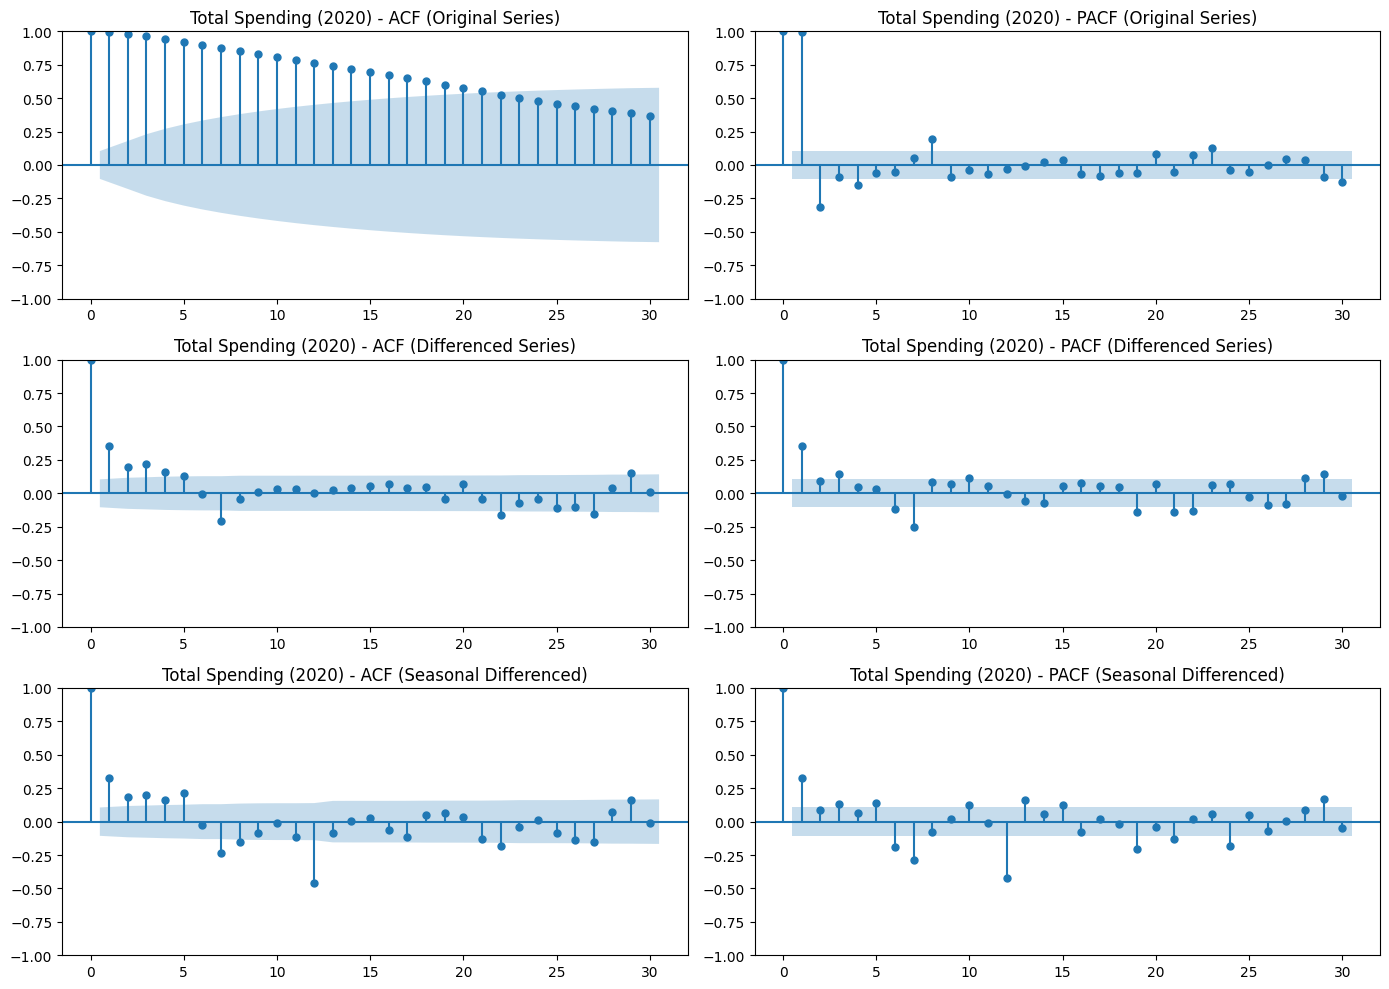

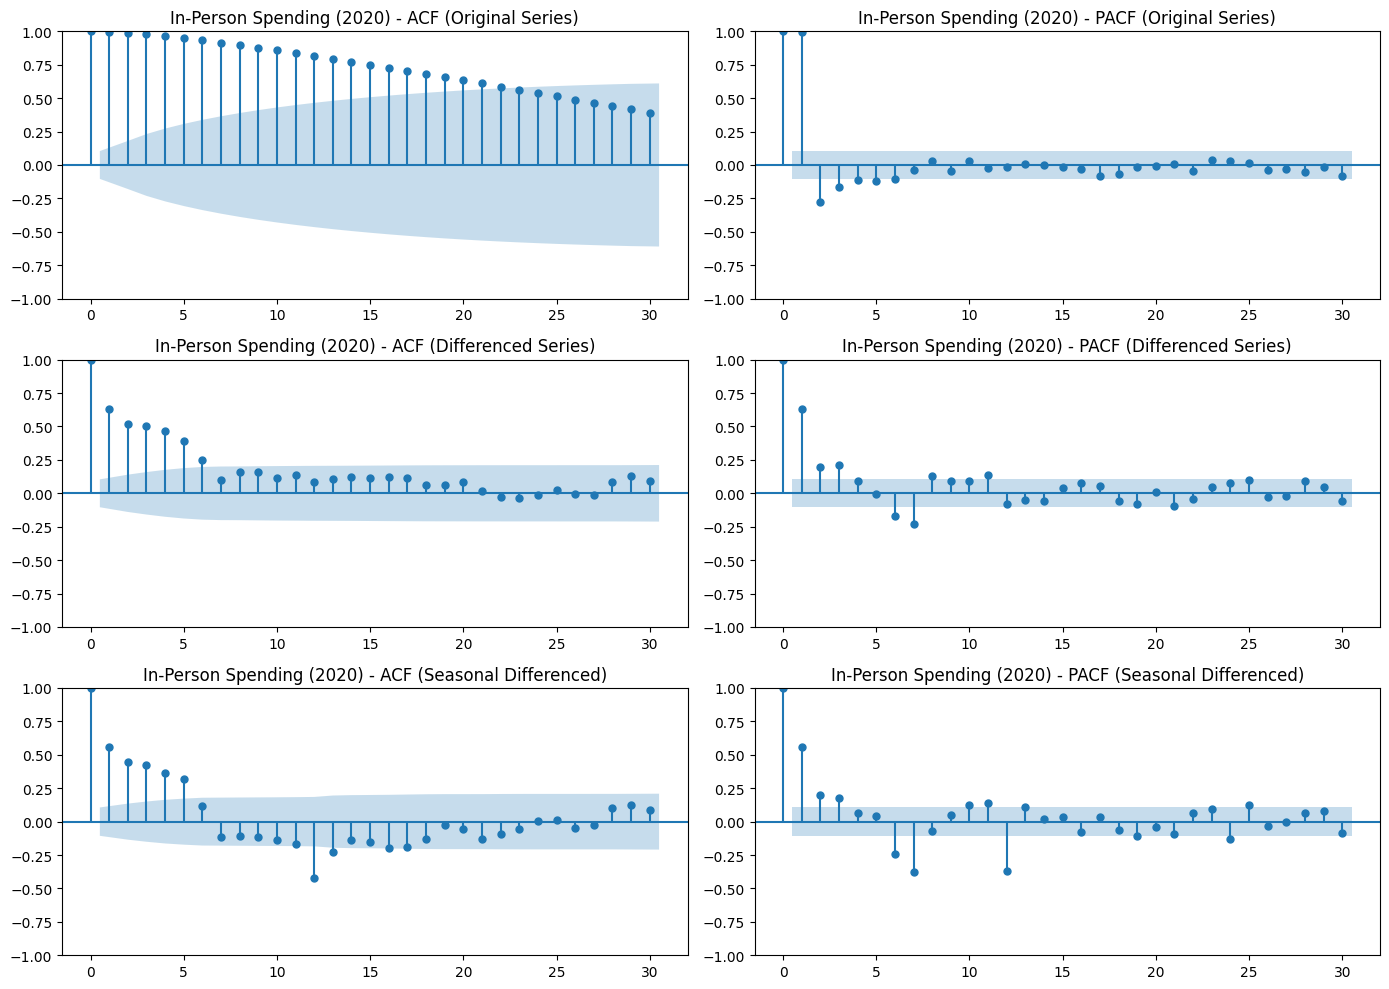


=== Analysis for 2021 ===


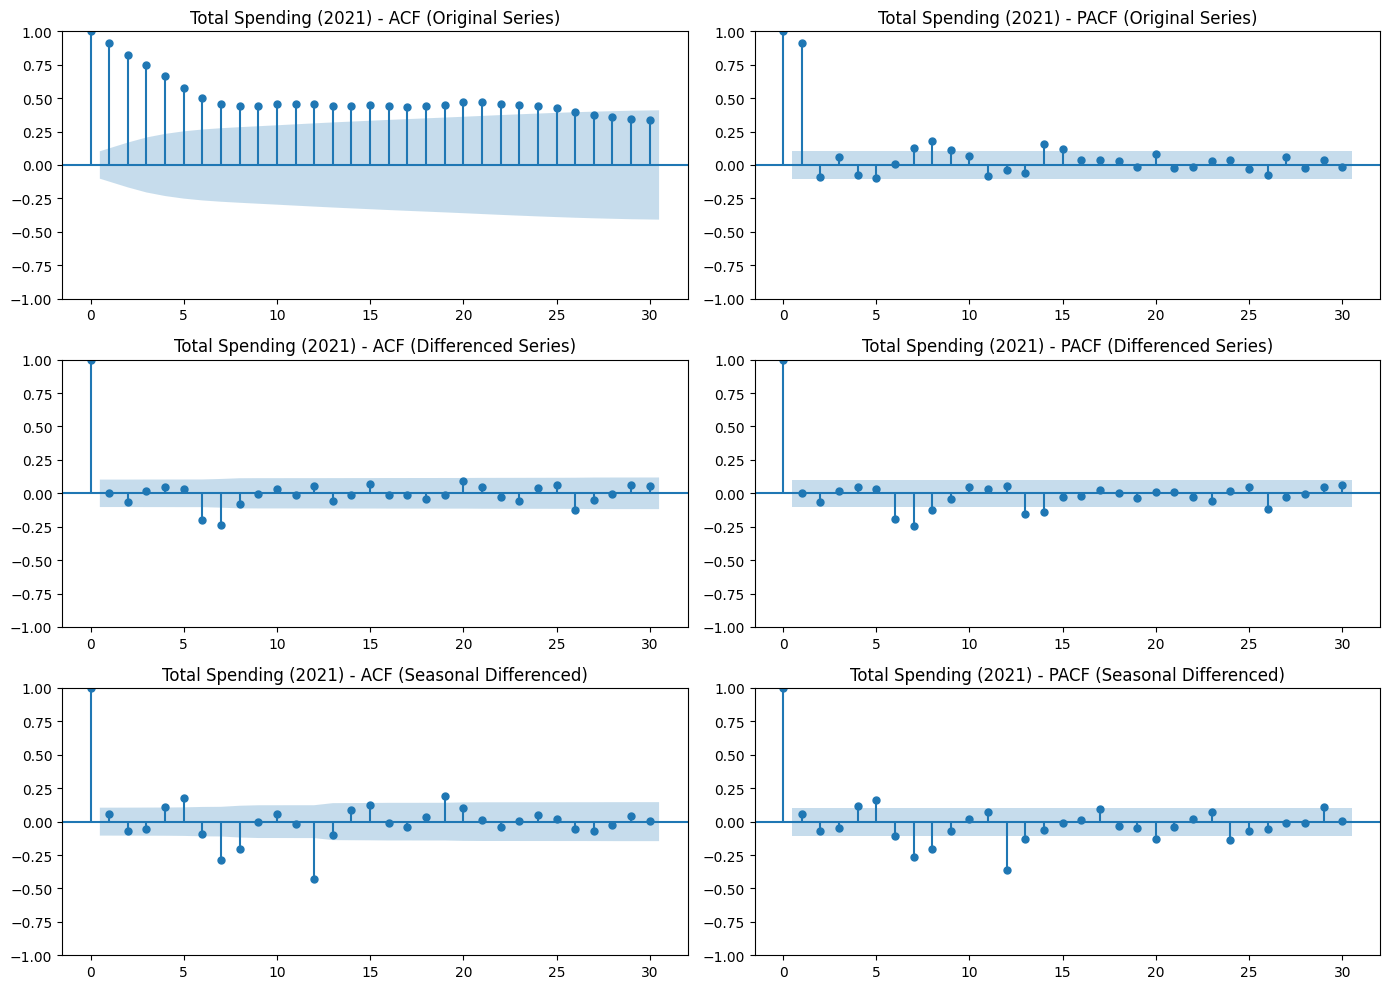

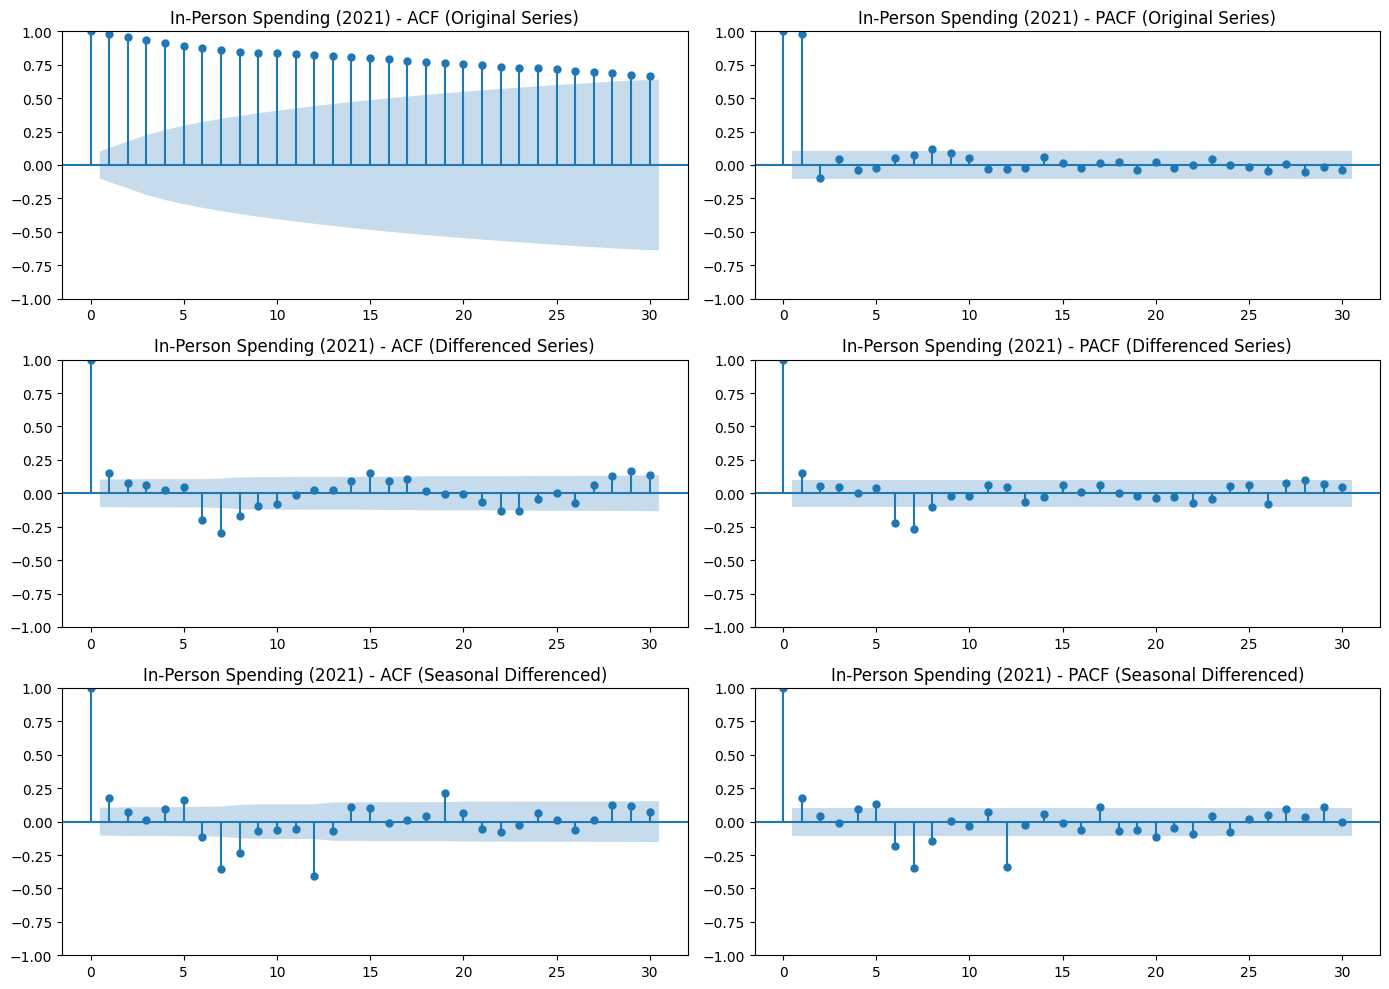


=== Analysis for 2022 ===


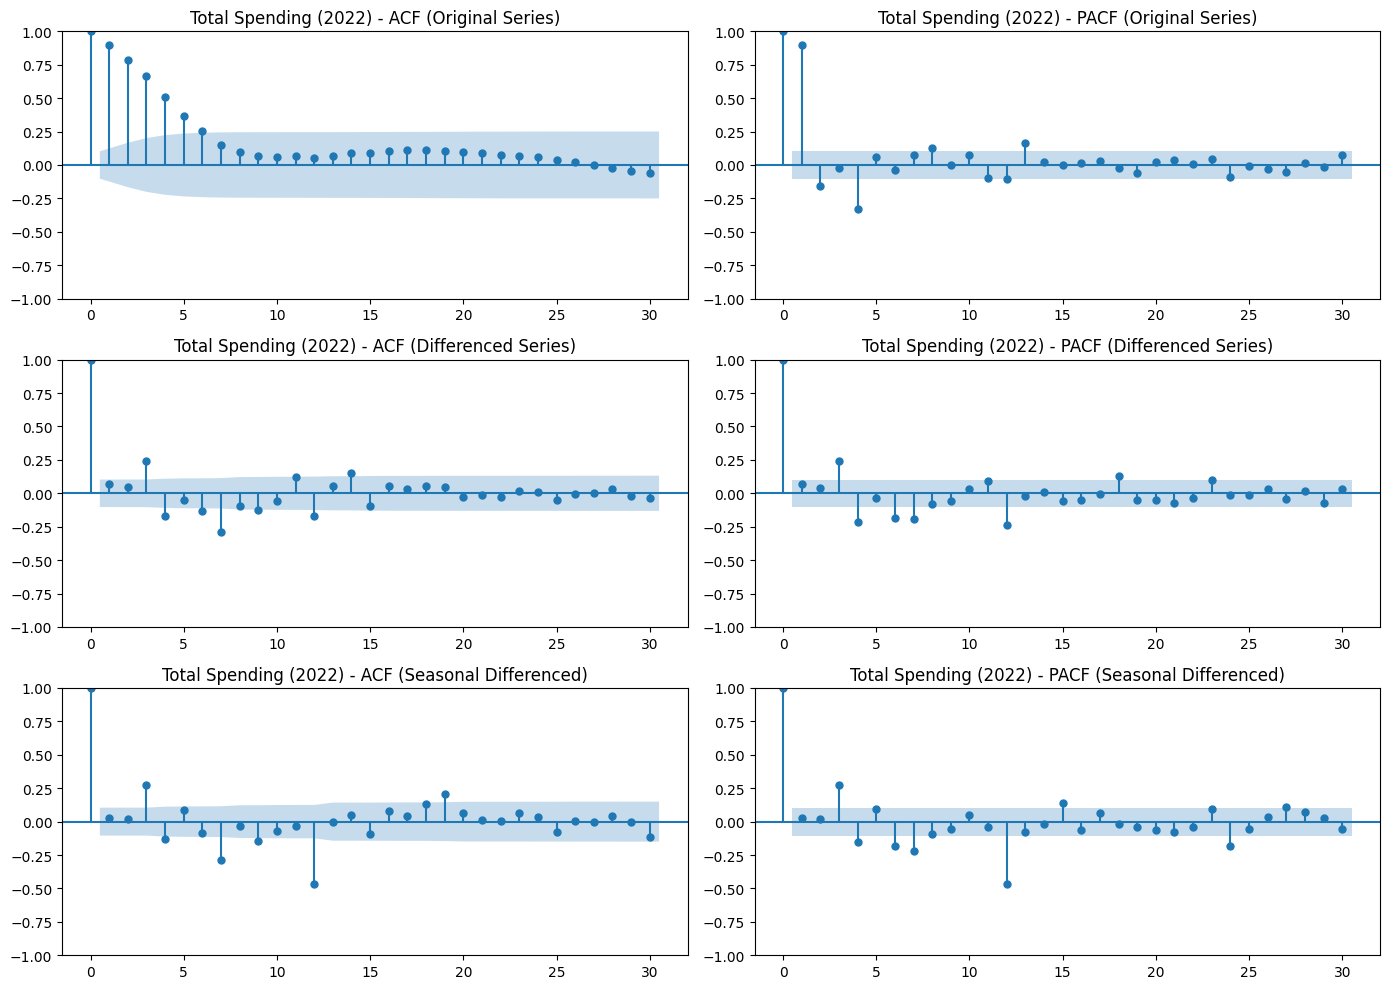

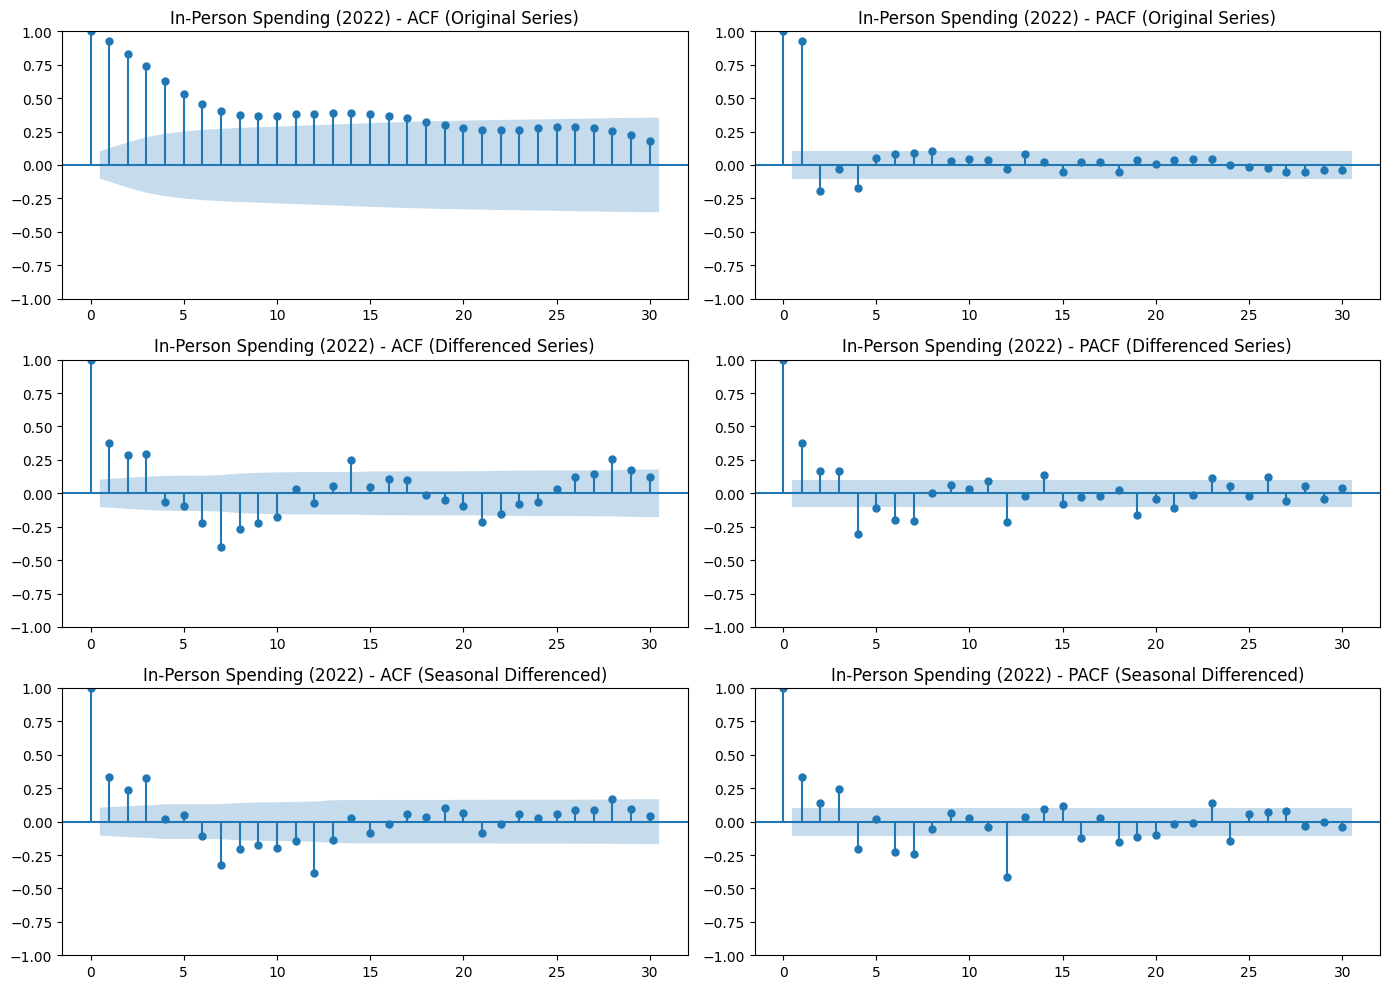

In [27]:
# Ensure all relevant columns are numeric
affinity_data['spend_all'] = pd.to_numeric(affinity_data['spend_all'], errors='coerce')
affinity_data['spend_inperson'] = pd.to_numeric(affinity_data['spend_inperson'], errors='coerce')

# Filter data for 2020, 2021, and 2022 only
affinity_data = affinity_data[affinity_data.index.year > 2019]

# Segment the data into years and analyze
for year in [2020, 2021, 2022]:
    print(f"\n=== Analysis for {year} ===")
    year_data = affinity_data[affinity_data.index.year == year]

    # Analyze the primary series (spend_all) and exogenous series (spend_inperson)
    if not year_data['spend_all'].dropna().empty:
        plot_acf_pacf(year_data['spend_all'].dropna(), f"Total Spending ({year})")
    if not year_data['spend_inperson'].dropna().empty:
        plot_acf_pacf(year_data['spend_inperson'].dropna(), f"In-Person Spending ({year})")


## **Analysis of Segmented ACF and PACF Insights**

This section highlights the key observations from the ACF and PACF plots of `spend_all` and `spend_inperson`. These insights guide the modeling process by identifying trends, short-term autocorrelation, and seasonal patterns. By analyzing the original, differenced, and seasonally differenced series, we assess the data's stationarity and determine the appropriate components for ARIMA and SARIMA models.



### Original Series
   - **ACF (Autocorrelation Function):**
     - The ACF for both `spend_all` and `spend_inperson` shows a **strong persistence** (slow decay) over lags.
     - This indicates a clear trend in the data, meaning the series are non-stationary.
     - The slow decay confirms the need for differencing to remove this trend.

   - **PACF (Partial Autocorrelation Function):**
     - The PACF shows a **large spike at lag 1** for all years, suggesting that an **AR(1)** model might be appropriate after differencing.
     - This spike indicates that the series can be explained by its most recent value (lag 1).



### Differenced Series
   - **ACF:**
     - After applying first differencing, the ACF for `spend_all` and `spend_inperson` shows much faster decay, indicating that the trend has been successfully removed.
     - The remaining significant spikes at early lags suggest some short-term autocorrelation.

   - **PACF:**
     - For the differenced series, the PACF shows significant spikes at **lag 1** and potentially at lag 2.
     - This suggests that an **ARIMA(1,1,0)** or **ARIMA(2,1,0)** model could be appropriate for capturing the short-term autocorrelation after differencing.

### Seasonally Differenced Series (12-Month Lag):**
   - **ACF:**
     - Seasonal differencing removes some of the periodic patterns seen in the original series.
     - The ACF for the seasonally differenced series still shows small spikes at lags 12, 24, etc., indicating **seasonality** in the data.

   - **PACF:**
     - The PACF for the seasonally differenced series has small spikes at lag 1 and sometimes at lag 12.
     - This suggests that the seasonal behavior is less pronounced after differencing but still needs to be considered in the model.

### **Comparison Across Years**

- **2020 (_Pandemic Onset_):**
   - The ACF shows strong autocorrelation, reflecting the **sharp economic shock** and sustained impact.
   - Differencing effectively removes the trend, leaving some short-term autocorrelation.

- **2021 (_Recovery Phase_):**
   - The trend is still visible in the original series, but differencing stabilizes the series.
   - Seasonal effects are more visible in 2021 compared to 2020, likely due to changes in spending patterns as restrictions eased.

- **2022 (_Return to Normalcy_):**
   - The ACF and PACF patterns for 2022 are more stable compared to previous years.
   - Differencing removes the trend effectively, and seasonal effects remain relatively minor.




### **Implications for Modeling**

The analysis of ACF and PACF reveals that differencing is essential to stabilize the series and remove underlying trends, ensuring the data is suitable for time series modeling. The patterns observed suggest that an ARIMA(1,1,0) or ARIMA(2,1,0) model would effectively capture short-term autocorrelation in the data. Furthermore, the seasonal effects observed at a lag of 12 highlight the importance of incorporating a seasonal component, necessitating the use of a SARIMA model to account for annual periodicity.

Moving forward, ARIMA and SARIMA models will be implemented for each year using the differenced series to ensure proper handling of trends and seasonality. Additionally, the spend_inperson variable will be incorporated as an exogenous variable, after undergoing similar preprocessing, to capture its influence on total spending.


## **ARIMA Modeling for Consumer Spending Forcast**

1. **Objective**:
   - Build ARIMA/SARIMA models for each year (2020, 2021, 2022) using the primary series (`spend_all`).
   - Include the exogenous variable (`spend_inperson`) for better forecasting.

2. **Steps**:
   - Use the differenced and seasonally differenced series for modeling.
   - Apply the **SARIMAX** model, which handles both seasonal and non-seasonal components while incorporating exogenous variables.
   - Evaluate model fit using metrics like **AIC** and residual diagnostics.


### SARIMAX Models

The **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)** model extends the ARIMA framework by incorporating seasonal components and external explanatory variables (e.g., **in-person spending**). This enables the model to capture:
- **Internal patterns** in the target variable (`spend_all`) through autoregressive and moving average components.
- **Seasonal effects**, such as periodic fluctuations in spending behavior.
- **Influence of external factors**, like in-person spending, which reflects consumer behavior and economic trends.

By integrating these components, the SARIMAX model offers a more comprehensive and accurate framework for understanding and forecasting changes in consumer spending. Below is the code to fit and evaluate the SARIMAX model for each year in the dataset (2020, 2021, 2022). The model diagnostics and residual analysis are also included to assess model performance.

In [28]:
# Define a function for SARIMAX modeling and diagnostics
def fit_sarimax(train_series, exog_series, order, seasonal_order, year):
    print(f"\n=== SARIMAX Model for {year} ===")

    # Fit the SARIMAX model
    model = SARIMAX(
        train_series,
        exog=exog_series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    # Display model summary
    print(results.summary())

    # Plot diagnostics
    results.plot_diagnostics(figsize=(14, 8))
    plt.suptitle(f"Model Diagnostics for {year}", y=1.02, fontsize=16)
    plt.show()

    return results


The SARIMAX model's non-seasonal (`order`) and seasonal (`seasonal_order`) parameters for each year are commom, and meant to capture short-term dependencies and annual seasonal patterns in the data.

In [29]:
# Model parameters
order = (1, 1, 0)  # ARIMA(p, d, q) for non-seasonal component
seasonal_order = (1, 1, 0, 12)  # SARIMA(P, D, Q, S) for seasonal component

In [30]:
# Common function to fit models for 2020, 2021, and 2022
def fit_sarimax_model(year):
    # Filter data for the year
    year_data = affinity_data[affinity_data.index.year == year]

    # Extract primary series and exogenous series
    train_series = year_data['spend_all'].dropna()
    exog_series = year_data['spend_inperson'].dropna()

    # Align exogenous series with the primary series
    exog_series = exog_series.loc[train_series.index]

    # Fit SARIMAX model
    results = fit_sarimax(
        train_series,
        exog_series,
        order=order,
        seasonal_order=seasonal_order,
        year=year
    )

    return results

#### **SARIMAX Model for 2020**


=== SARIMAX Model for 2020 ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          spend_all   No. Observations:                  354
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                1152.358
Date:                            Sat, 21 Dec 2024   AIC                          -2296.716
Time:                                    03:18:21   BIC                          -2281.544
Sample:                                01-13-2020   HQIC                         -2290.663
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
spend_inperson     0.8137      0.027     29.885      0.000       0.760       0.867
ar.L1              0.39

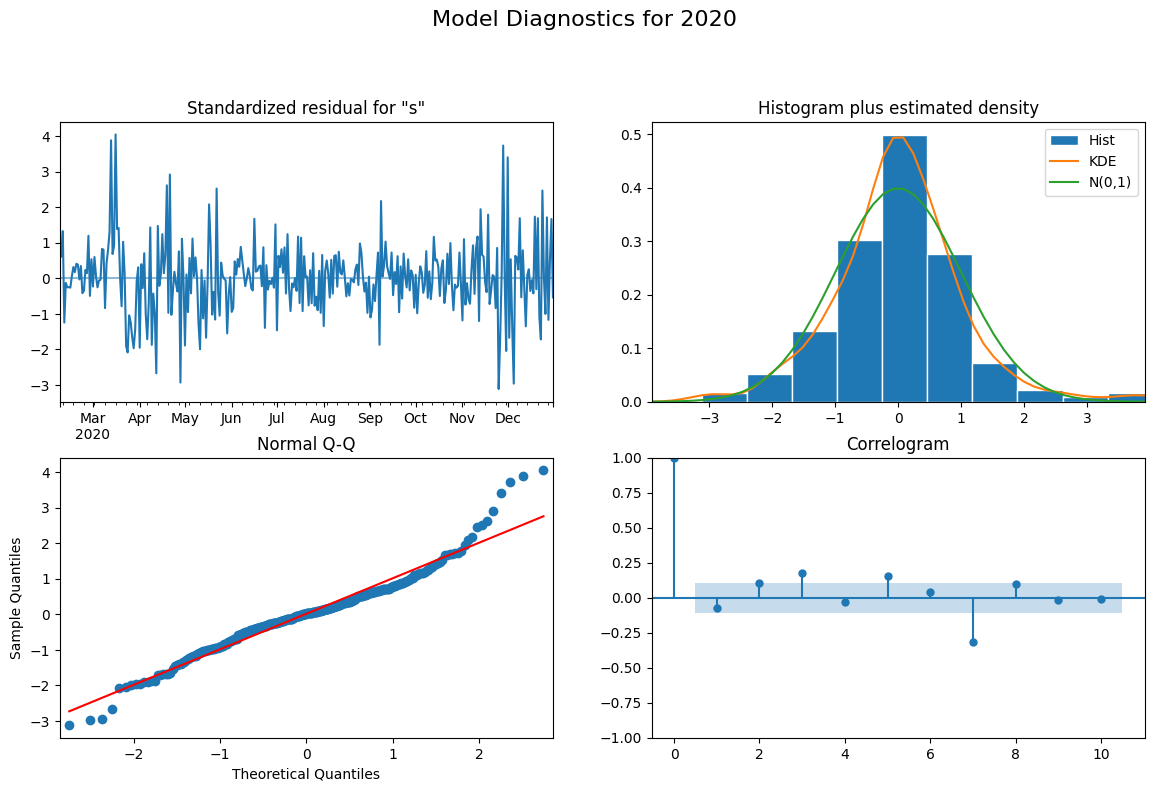

In [31]:
results_2020 = fit_sarimax_model(2020);

**Key Results**
- **Log Likelihood and AIC**:
   - The model achieved a **log-likelihood of 1152.358** and an **AIC of -2296.716**, indicating a good fit for the dataset.

- **Coefficients**:
   - **In-person spending (`spend_inperson`)**: Strong positive relationship (**coef: 0.8137**, **p < 0.001**) with total spending. This means an increase in in-person spending strongly predicts an increase in total spending.
   - **AR(1) (`ar.L1`)**: Significant positive coefficient (**coef: 0.3990**, **p < 0.001**) indicates that total spending is influenced by its immediate previous value.
   - **Seasonal AR(12) (`ar.S.L12`)**: Significant negative coefficient (**coef: -0.5816**, **p < 0.001**) suggests a seasonal dependency, with spending 12 months prior having an inverse relationship with current spending.

- **Residual Variance (`sigma2`)**:
   - The residual variance is very low (**5.19e-05**), indicating the model captures most of the variability in the data.

**Model Diagnostics**

- Standardized Residuals: they appear centered around zero with no visible patterns, suggesting the model is well-specified.

- Histogram and Q-Q Plot: Residuals follow a roughly normal distribution, though there are slight deviations in the tails. This is common with real-world financial data.

- Correlogram: No significant autocorrelation in the residuals, confirming that the model successfully accounts for dependencies in the data.

The SARIMAX model for 2020 performs well, capturing both short-term and seasonal dependencies in total spending while incorporating the impact of in-person spending. The significant coefficients and well-behaved residuals suggest that the model is robust and suitable for forecasting during this period. However, slight non-normality in residuals could be explored further if needed.

#### **SARIMAX Model for 2021**


=== SARIMAX Model for 2021 ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          spend_all   No. Observations:                  365
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                1181.704
Date:                            Sat, 21 Dec 2024   AIC                          -2355.407
Time:                                    03:18:24   BIC                          -2340.103
Sample:                                01-01-2021   HQIC                         -2349.309
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
spend_inperson     0.8957      0.023     38.549      0.000       0.850       0.941
ar.L1              0.22

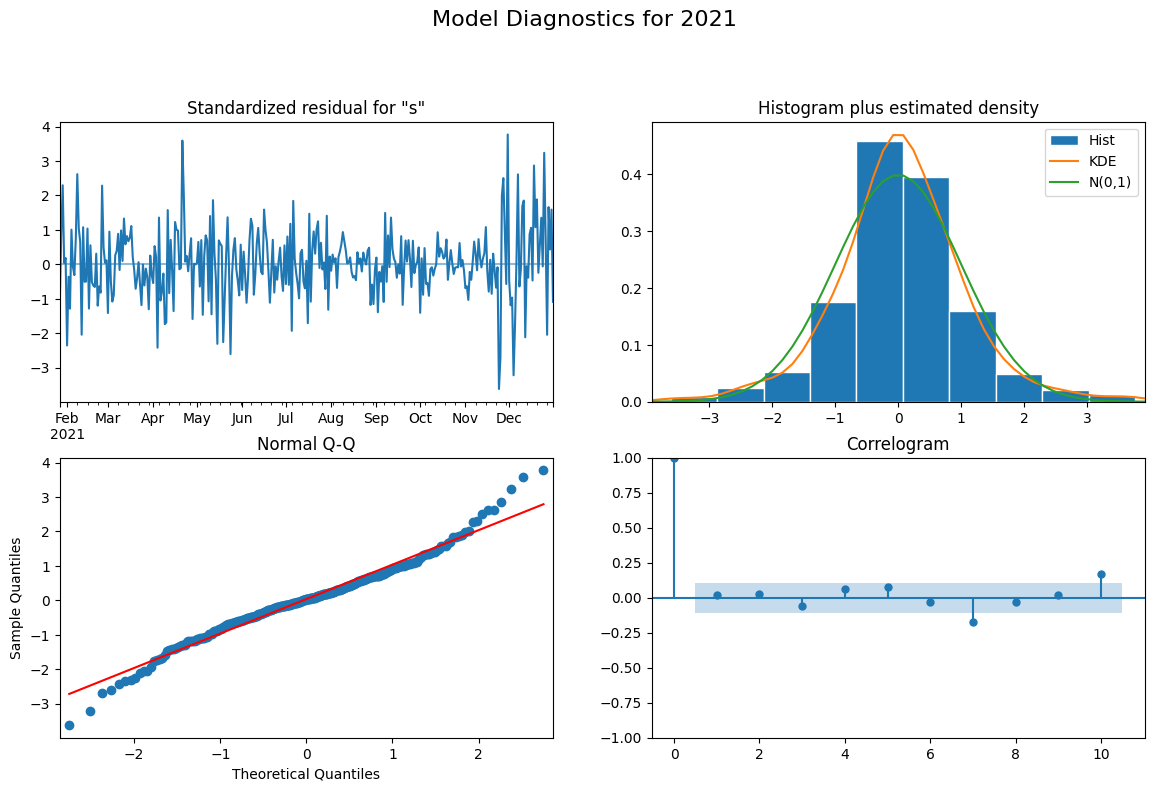

In [32]:
results_2021 = fit_sarimax_model(2021);

**Key Results**

- **Log Likelihood and AIC**:
   - The model achieved a **log-likelihood of 1181.704** and an **AIC of -2355.407**, indicating a good fit.

- **Coefficients**:
   - **In-person spending (`spend_inperson`)**: Strong positive coefficient (**coef: 0.8957**, **p < 0.001**) indicates that in-person spending is a highly significant predictor of total spending, with nearly a one-to-one relationship.
   - **AR(1) (`ar.L1`)**: Positive coefficient (**coef: 0.2277**, **p < 0.001**) shows that total spending is influenced by its value in the previous period.
   - **Seasonal AR(12) (`ar.S.L12`)**: Significant negative coefficient (**coef: -0.4894**, **p < 0.001**) reflects an inverse relationship with spending from 12 months prior.

- **Residual Variance (`sigma2`)**:
   - Low variance (**5.487e-05**) suggests that the model explains most of the variability in the data.

**Model Diagnostics**

- Standardized Residuals: appear well-centered around zero with no visible patterns, indicating the model is well-specified.

- Histogram and Q-Q Plot: Residuals follow a roughly normal distribution, with slight deviations in the tails. These deviations may be due to some outlier spending patterns during the recovery phase.

- Correlogram: No significant autocorrelation is observed in the residuals, confirming that the model successfully captures the dependencies in the data.


The SARIMAX model for 2021 performs well in capturing total spending trends during the recovery period. The strong correlation between in-person spending and total spending aligns with the gradual return to pre-pandemic behavior. The seasonal autoregressive term further reflects changes in consumer patterns compared to the same period in 2020. Residuals indicate a good model fit, although slight non-normality may require further exploration if higher precision is needed.

#### **SARIMAX Model for 2022**


=== SARIMAX Model for 2022 ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          spend_all   No. Observations:                  365
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                1266.861
Date:                            Sat, 21 Dec 2024   AIC                          -2525.722
Time:                                    03:18:28   BIC                          -2510.418
Sample:                                01-01-2022   HQIC                         -2519.624
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
spend_inperson     0.6225      0.020     31.833      0.000       0.584       0.661
ar.L1              0.42

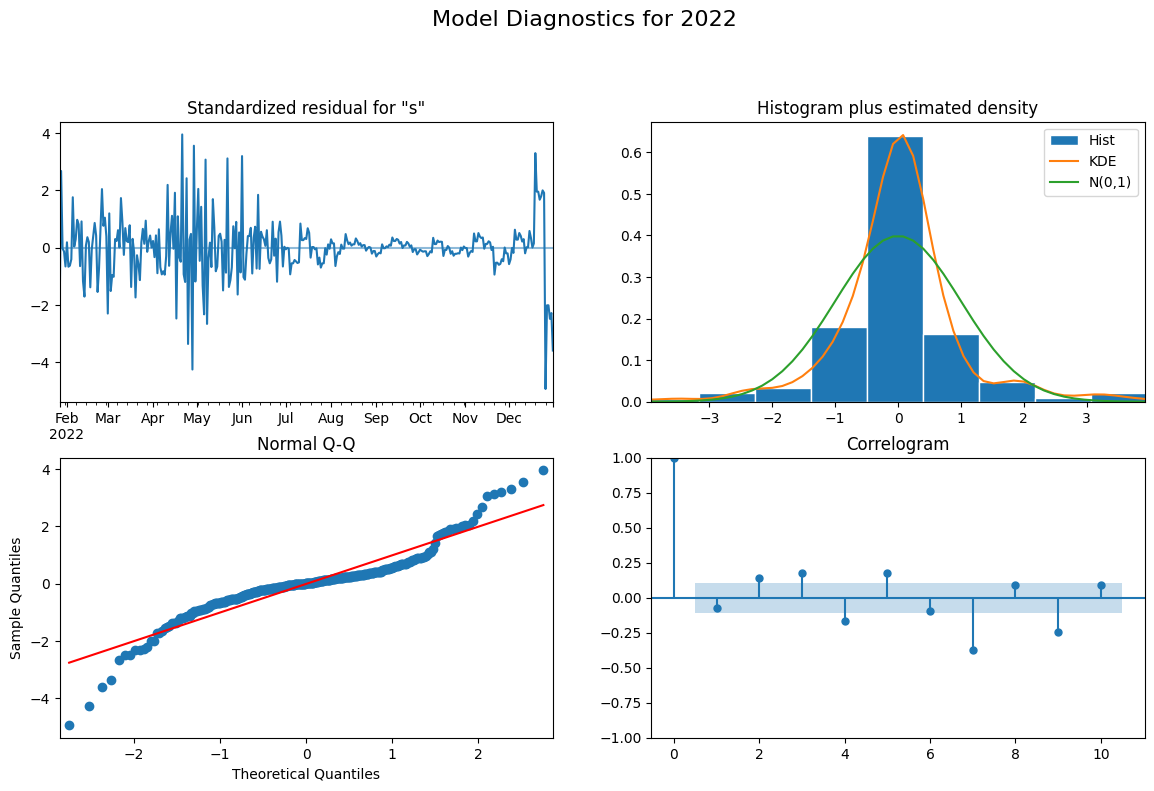

In [33]:
results_2022 = fit_sarimax_model(2022);

**Key Results**

The SARIMAX model for 2022 was trained with **365 daily observations**, accounting for seasonal effects and the exogenous variable `spend_inperson`. Key findings include:

- **Log-Likelihood and AIC**:
   - 2022 model achieves a **Log-Likelihood** of 1266.861 and **AIC** of -2525.722 (improved significantly compared to previous iterations), indicating a good balance between model complexity and fit.

- **Model Coefficients**:
   - **In-person spending (`spend_inperson`)**: Positive and significant (**coef: 0.6225**, **p < 0.001**), suggesting a strong relationship between in-person and total spending.
   - **AR(1) (`ar.L1`)**: Positive and significant (**coef: 0.4268**, **p < 0.001**), indicating that recent past values contribute to current spending.
   - **Seasonal AR(12) (`ar.S.L12`)**: Significant negative coefficient (**coef: -0.5851**, **p < 0.001**), reflecting a strong inverse seasonal dependency with spending 12 months prior.

- **Residual Variance (`sigma2`)**:
   - Exceptionally low (**3.319e-05**), demonstrating that the model explains most of the variance in the data.






**Model Diagnostics**

- Standardized Residuals: the esiduals remain mostly centered around zero, but a **sharp spike in December 2022** suggests the presence of an unmodeled anomaly or external factor.

- Histogram and Q-Q Plot: Residuals generally conform to a normal distribution, but slight skewness and heavy tails indicate the influence of outliers, especially toward year-end.

- Correlogram: Minimal residual autocorrelation confirms the model captures temporal dependencies effectively.

- Jarque-Bera Test: High test statistic and low p-value highlight deviations from normality in residuals, mainly due to **outliers and heteroskedasticity**.

**Key Observations and difference over previous years**

- Seasonal and Trend Dynamics:
  - The model effectively captures both short-term (AR) and seasonal (12-month lag) dependencies in spending.
  - The influence of in-person spending has reduced slightly compared to prior years, likely reflecting shifts in consumer behavior.

- Late-Year Volatility:
  - December 2022 demonstrates significant volatility, with potential external factors influencing the residuals (e.g., macroeconomic shocks or data anomalies).


This SARIMAX model for 2022 achieves strong performance, balancing trend, seasonality, and external influences. However, handling late-year anomalies could improve its robustness. Further exploration of the sharp residual spikes, along with consideration of other exogenous variables or interventions, may yield additional insights.

### **Forecasting Consumer Spending for December**

In this section, we leverage SARIMAX models to forecast consumer spending (`spend_all`) for the month of December in the years 2020, 2021, and 2022. By isolating December, the analysis focuses on the critical holiday season, a period characterized by significant economic activity and unique spending patterns. Forecasting during this time provides insights into the model's performance under varying economic conditions and captures the trends influenced by external factors such as economic recovery and seasonal behaviors. The accompanying plots visualize the forecasts alongside the actual observed values, allowing for a detailed evaluation of the model's accuracy and reliability.

In [34]:
# Define a function for forecasting with improved index handling
def forecast_for_december(year, model_results):
    print(f"\n=== Forecasting for December {year} ===")

    # Define the date range for December
    forecast_start_date = f"{year}-12-01"
    forecast_end_date = f"{year}-12-31"

    # Ensure exogenous data is aligned and without gaps
    exog_forecast = affinity_data.loc[forecast_start_date:forecast_end_date, 'spend_inperson']
    exog_forecast = exog_forecast.ffill().bfill()
    actuals = affinity_data.loc[forecast_start_date:forecast_end_date, 'spend_all'].dropna()

    # Ensure index compatibility
    exog_forecast = exog_forecast.reindex(actuals.index)

    # Check if there is enough data to proceed
    if exog_forecast.empty or actuals.empty:
        print(f"Not enough data to forecast for December {year}. Skipping.")
        return None

    # Generate forecast
    forecast = model_results.get_forecast(steps=len(actuals), exog=exog_forecast)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Evaluate forecast performance
    mae = mean_absolute_error(actuals, forecast_values)
    rmse = np.sqrt(mean_squared_error(actuals, forecast_values))

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Plot forecast versus actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actuals.index, actuals, label="Actual", color="blue")
    plt.plot(actuals.index, forecast_values, label="Forecast", color="red")
    plt.fill_between(
        actuals.index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color="pink",
        alpha=0.3,
        label="Confidence Interval"
    )
    plt.title(f"SARIMAX Forecast vs Actual for December {year}")
    plt.legend()
    plt.show()

    return forecast_values


This function forecasts consumer spending for the month of December of a given year using a SARIMAX model and evaluates its performance against actual observed data. It works as follows:

- **Date Range Definition**: Defines the start and end dates for December of the specified year.
- **Exogenous Data Preparation**: Extracts and ensures the exogenous variable (`spend_inperson`) is complete by forward and backward filling missing values, ensuring alignment with the target variable (`spend_all`).
- **Data Alignment**: Reindexes the exogenous variable to match the index of the actual target data, ensuring compatibility for forecasting.
- **Data Validation**: Checks if sufficient data is available for the specified period; skips the forecast if data is insufficient.
- **Forecasting**: Generates forecasts and confidence intervals for the target variable using the SARIMAX model.
- **Performance Evaluation**: Computes performance metrics (MAE and RMSE) to assess forecast accuracy.
- **Visualization**: Plots the actual data, forecasted values, and confidence intervals for December, providing a visual comparison.

This function combines data preparation, forecasting, and evaluation into a single, streamlined process for forecasting December spending.

#### SARIMAX Forecast and Evaluation for December 2020


=== Forecasting for December 2020 ===
MAE: 0.0578
RMSE: 0.0608


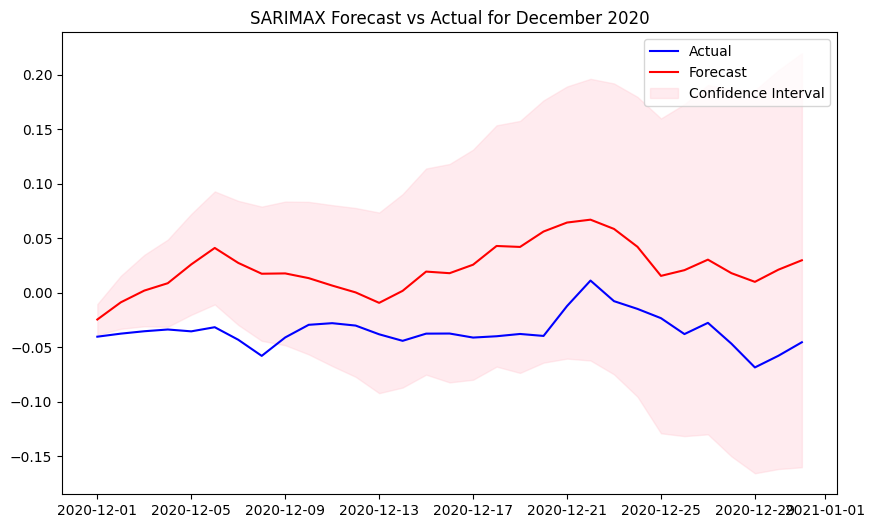

In [35]:
forecast_values_2020 = forecast_for_december(2020, results_2020)

The SARIMAX forecast for December 2020 shows a strong alignment with actual values, as evidenced by the **low error metrics** (see MAE and RMSE above the plot).

**Observations:**

   - The model effectively captures the general trend in consumer spending for December 2020. Both forecasted and actual values move in parallel, maintaining a consistent relationship.

   - Minor deviations between actual and forecast values are visible, especially during mid-December. These deviations may indicate small, unaccounted-for variations in external factors or noise in the data.

   - The actual values remain well within the **forecast confidence interval**, reinforcing the reliability of the model during this period.

   - December 2020 reflects the unique economic conditions of the COVID-19 pandemic, characterized by restrained consumer spending and shifting patterns. The model performs remarkably well in predicting these conditions, despite the external challenges.



The December 2020 forecast demonstrates high accuracy and reflects the model's capability to capture seasonal and trend dependencies. While minor residual gaps exist, the overall fit is robust, offering confidence for further forecasting applications.

#### SARIMAX Forecast and Evaluation for December 2021


=== Forecasting for December 2021 ===
MAE: 0.1544
RMSE: 0.1596


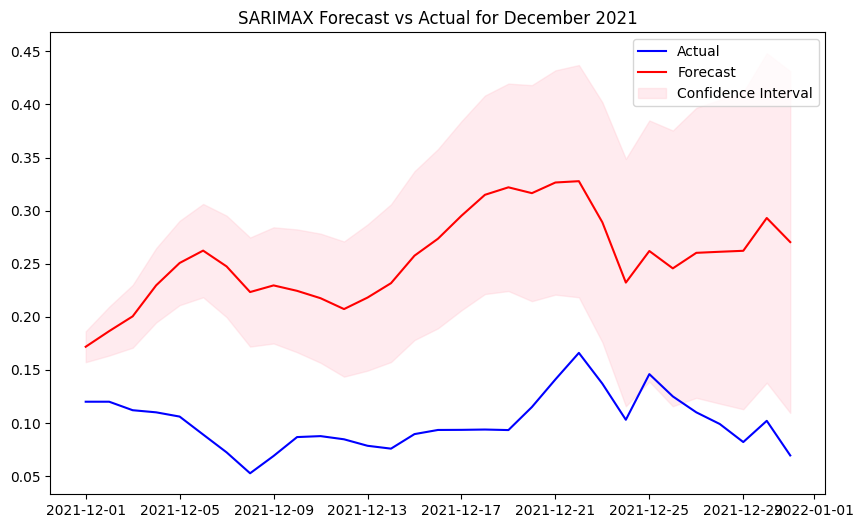

In [36]:
forecast_values_2021 = forecast_for_december(2021, results_2021)

The SARIMAX forecast for December 2021 demonstrates a noticeable divergence from the actual values, reflected in the **higher error metrics** (**MAE = $0.1544$** and **RMSE = $0.1596$**)

**Observations:**

   - The **forecast consistently overestimates consumer spending** throughout the month, with actual values remaining below the forecasted trend. This suggests a systematic bias, potentially tied to external factors not captured by the model.

   - Unlike December 2020, where trends aligned closely, the 2021 actuals show a flatter trend and lower spending levels, particularly toward the end of the month. This divergence highlights a mismatch in seasonal expectations.

   - While the forecast lies within the **upper bounds of the confidence interval**, the actual values remain at the **lower edge or outside** the interval. This suggests increased uncertainty in the model's predictions for December 2021.




**Economic Context:**

The discrepancies can be attributed to **economic and consumer behavior anomalies in late 2021**:

- **Reduced Consumer Confidence:** Acording to the [Bureau of Labor Statistics Consumer Price Index of December of 2021](https://www.bls.gov/news.release/archives/cpi_01122022.pdf), rising inflation rates in late 2021 eroded purchasing power and altered spending habits, as indicated in [The Conference Board's Consumer Confidence Index for December 2021](https://www.conference-board.org/topics/consumer-confidence).

- **Supply Chain Disruptions:** Ongoing global supply chain challenges limited product availability during the holiday season, further suppressing consumer spending. Ref: [10 disruptions that rocked supply chains in 2021](https://www.supplychaindive.com/news/top-supply-chain-disruptions-2021/611513/)

- **COVID-19 Omicron Variant:** The emergence of the Omicron variant in late 2021 led to renewed restrictions and uncertainty, dampening in-person spending and holiday activities. Ref: [SARS-CoV-2 B.1.1.529 (Omicron) Variant, CDC Reports, December 2021](https://www.cdc.gov/mmwr/volumes/70/wr/mm7050e1.htm)

- **Shifts in Spending Patterns:** Consumers shifted from discretionary spending to essentials, which may not be fully captured in the `spend_inperson` variable used as an exogenous factor. Ref: [The Impact of Consumer Purchase Behavior Changes on the Business Model Design of Consumer Services Companies Over the Course of COVID-19](https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2022.818845/full)



The December 2021 forecast highlights the SARIMAX model's limitations in accounting for external shocks, such as inflation, supply chain issues, and pandemic-related shifts.

While the model adequately captures historical patterns, the observed gap underscores the need for more dynamic external predictors or model adjustments to account for real-world uncertainties.

#### SARIMAX Forecast and Evaluation for December 2022


=== Forecasting for December 2022 ===
MAE: 0.0452
RMSE: 0.0670


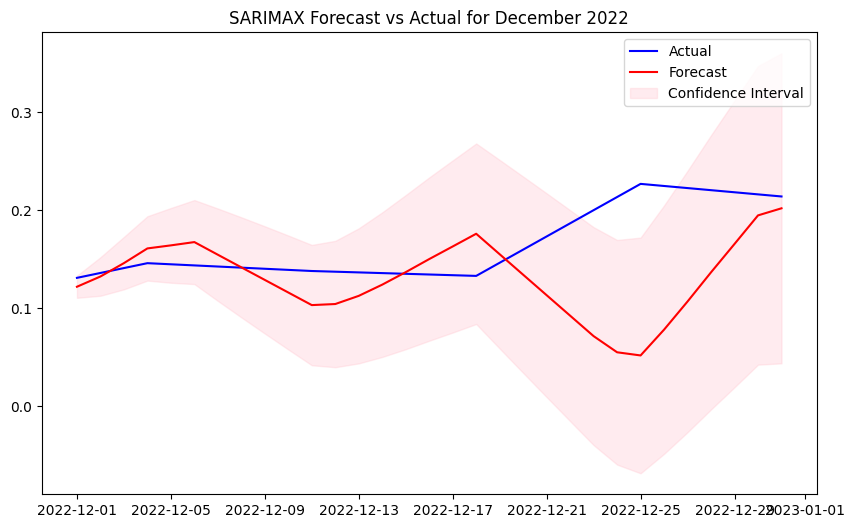

In [37]:
forecast_values_2022 = forecast_for_december(2022, results_2022)

The SARIMAX forecast for December 2022 exhibits closer alignment with the actual values compared to 2021, reflected in the improved error metrics.

**Observations:**

   - The **forecast follows the overall trend of actual consumer spending** more closely than in previous years, particularly during the first two weeks of December.

   - However, the forecast underestimates spending during the latter half of the month, as the actual values increase significantly, breaking the earlier trend.

   - The forecast stays well within the **confidence interval**, and the interval narrows during the first half of the month, reflecting greater certainty in the model's predictions during this period. The widening interval at the end of December corresponds to the underestimation of the actual values.

   - A noticeable upward shift in spending is observed toward the final week of December, which the model fails to anticipate, likely due to sudden or external influences.



The SARIMAX model for December 2022 performed better than previous years in predicting consumer spending trends, capturing much of the seasonality and exogenous influences. However:

- The **upward spike in late December spending** highlights limitations in the model's ability to adapt to external or unexpected drivers of consumer behavior.

- Incorporating additional exogenous variables, such as promotional activity or adjusted inflation metrics, could further enhance forecast accuracy for highly dynamic periods.

## **Bayesian Modeling for Consumer Spending and Employment Trends**


This section applies Bayesian hierarchical models to analyze the relationships between consumer spending, employment rates, and unemployment claims. Bayesian models allow us to incorporate prior knowledge and assess uncertainty in parameter estimates, providing a more nuanced understanding of the interdependencies in the data.



### Foundational Bayesian Model

This Bayesian regression model provides detailed insights into the relationship between consumer spending (`spend_all`) and its predictors: unemployment claims (`initclaims_count_regular`) and employment rate (`emp`). The posterior distributions and trace plots presented here evaluate the convergence of our model parameters and their uncertainty.

Output()

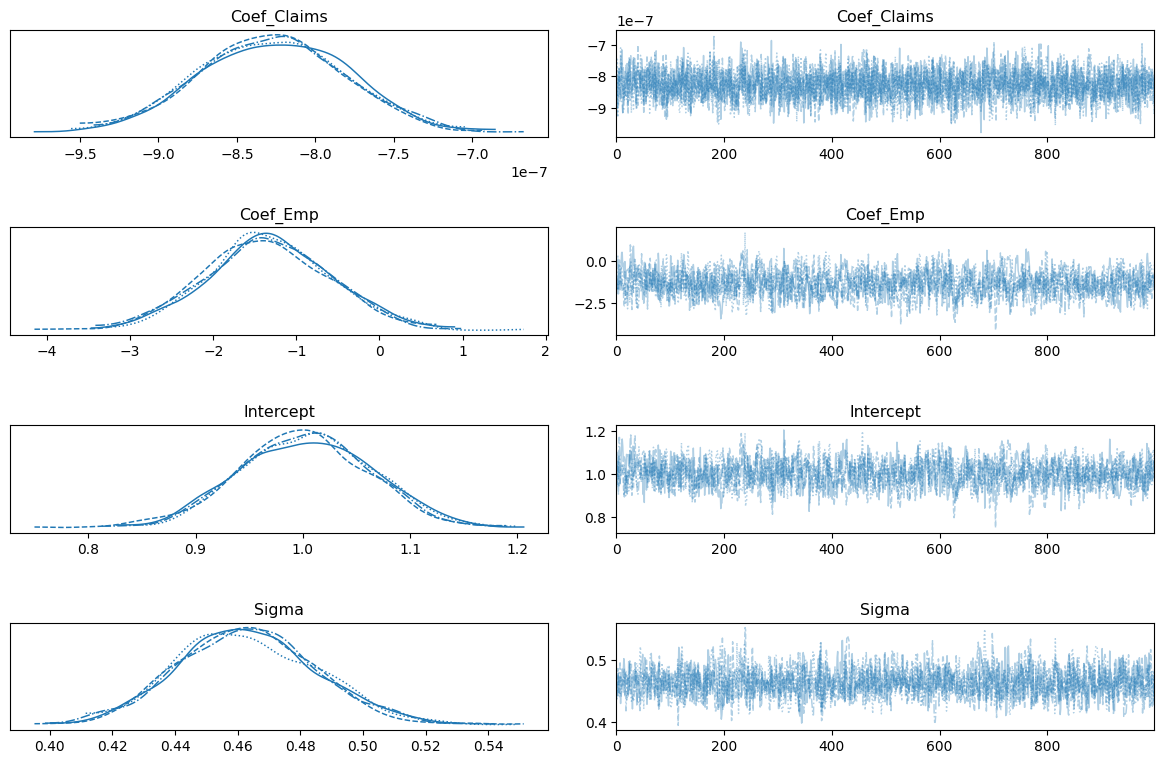

In [38]:
# Extract the necessary columns for modeling
data = merged_weekly_data[['spend_all', 'emp', 'initclaims_count_regular']].dropna()

# Standardize the variables for numerical stability
data['spend_all_z'] = (data['spend_all'] - data['spend_all'].mean()) / data['spend_all'].std()
data['emp_z'] = (data['emp'] - data['emp'].mean()) / data['emp'].std()
data['initclaims_z'] = (data['initclaims_count_regular'] - data['initclaims_count_regular'].mean()) / data['initclaims_count_regular'].std()

# Define the Bayesian model
with pm.Model() as bayesian_model:
    # Define priors for regression coefficients
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    coef_emp = pm.Normal('Coef_Emp', mu=0, sigma=1)
    coef_claims = pm.Normal('Coef_Claims', mu=0, sigma=1)
    sigma = pm.HalfNormal('Sigma', sigma=1)

    # Define the linear regression model (mu)
    mu = (
        intercept +
        coef_emp * merged_weekly_data['emp'] +
        coef_claims * merged_weekly_data['initclaims_count_regular']
    )

    # Define the likelihood (observed data)
    spend_all_obs = pm.Normal(
        'spend_all',
        mu=mu,
        sigma=sigma,
        observed=merged_weekly_data['spend_all']
    )

    # Sample from the posterior distribution
    trace = pm.sample(1000, return_inferencedata=True)

# Traceplot
pm.plot_trace(trace)
plt.tight_layout(pad=2.0)
plt.show()


**Model Diagnostics Summary**

- Posterior Distributions: The left-hand plots display the posterior distributions for the coefficients of unemployment claims, employment rate, the intercept, and sigma (variance). These distributions indicate the range and uncertainty of each parameter.

 - `Coef_Claims`: A negative distribution suggests that an increase in unemployment claims reduces total consumer spending.
 - `Coef_Emp`: A weakly negative to near-zero distribution highlights minimal influence of employment rate on spending, though there is a trend toward lower spending with higher employment.
 - `Intercept`: The intercept centers near zero, indicating no strong baseline effect in the absence of predictors.
 - `Sigma`: The residual variance shows tight uncertainty bounds, suggesting the model fits the data well.

- Trace Plots: The right-hand plots show the sampling behavior for each parameter across iterations. These traces exhibit good mixing and convergence without significant divergences or drifts, confirming a stable MCMC sampling process.



### Bayesian Model Diagnostics Per Year

This section evaluates the Bayesian models built for each year, providing insights into the relationships between key economic indicators such as total consumer spending, employment levels, and unemployment claims. Diagnostics such as posterior distributions, trace plots, and posterior predictive checks are used to assess model convergence, parameter credibility, and predictive accuracy. These diagnostics ensure the robustness of the models and highlight year-to-year variations in economic behavior.

In [39]:
# Build and run a Bayesian model for the specified year
def bayesian_model_per_year(data, year):
    # Filter data for the specified year
    year_data = data[data['date'].dt.year == year]

    # Define predictors and target variable
    emp = year_data['emp'].values
    claims = year_data['initclaims_count_regular'].values
    spend = year_data['spend_all'].values

    with pm.Model() as model:
        # Priors
        intercept = pm.Normal("Intercept", mu=0, sigma=1)
        coef_emp = pm.Normal("Coef_Emp", mu=0, sigma=1)
        coef_claims = pm.Normal("Coef_Claims", mu=0, sigma=1)
        sigma = pm.HalfNormal("Sigma", sigma=1)

        # Expected value of the dependent variable
        mu = intercept + coef_emp * emp + coef_claims * claims

        # Likelihood (sampling distribution) of observations
        spend_obs = pm.Normal("spend_all", mu=mu, sigma=sigma, observed=spend)

        # Sampling with increased target_accept to address divergences
        trace = pm.sample(
            1000,
            tune=1000,
            target_accept=0.95,  # Increase target_accept to reduce divergences
            return_inferencedata=True,
            random_seed=42
        )

        # Posterior predictive checks (optional)
        posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=42)

    # Diagnostic plots using ArviZ
    az.plot_trace(trace)
    plt.suptitle(f"Bayesian Model Diagnostics for {year}", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Return the trace and posterior predictive samples
    return trace, posterior_predictive, model


To facilitate a more organized workflow, the code was updated to separately store the model traces and posterior predictive samples for each year. This allows for detailed diagnostics and predictions to be generated independently for each year's data, enabling clearer comparisons and further analysis.

The following diagnostic plots provide insights into the performance and convergence of Bayesian models built for predicting spend_all across the years 2020, 2021, and 2022. These models assess relationships between unemployment claims, employment data, and total consumer spending. Key parameters include the coefficients for unemployment claims (Coef_Claims), employment rate (Coef_Emp), intercept, and residual variance (Sigma). Each set of diagnostics includes posterior distributions and trace plots to evaluate parameter estimation and sampling convergence.


Output()

Output()

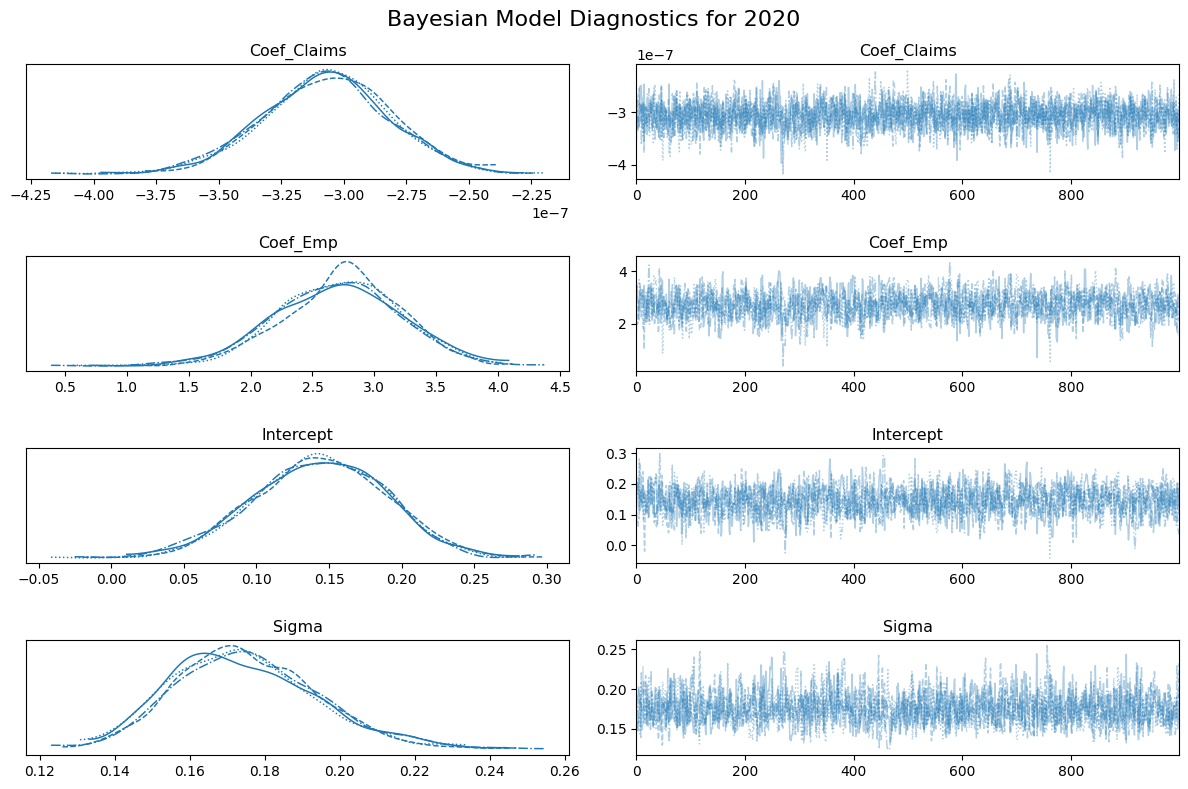

In [40]:
# Generate Bayesian model and store traces and posterior predictives for 2020
trace_2020, posterior_predictive_2020, bayesian_model_2020 = bayesian_model_per_year(merged_weekly_data, 2020)

Output()

Output()

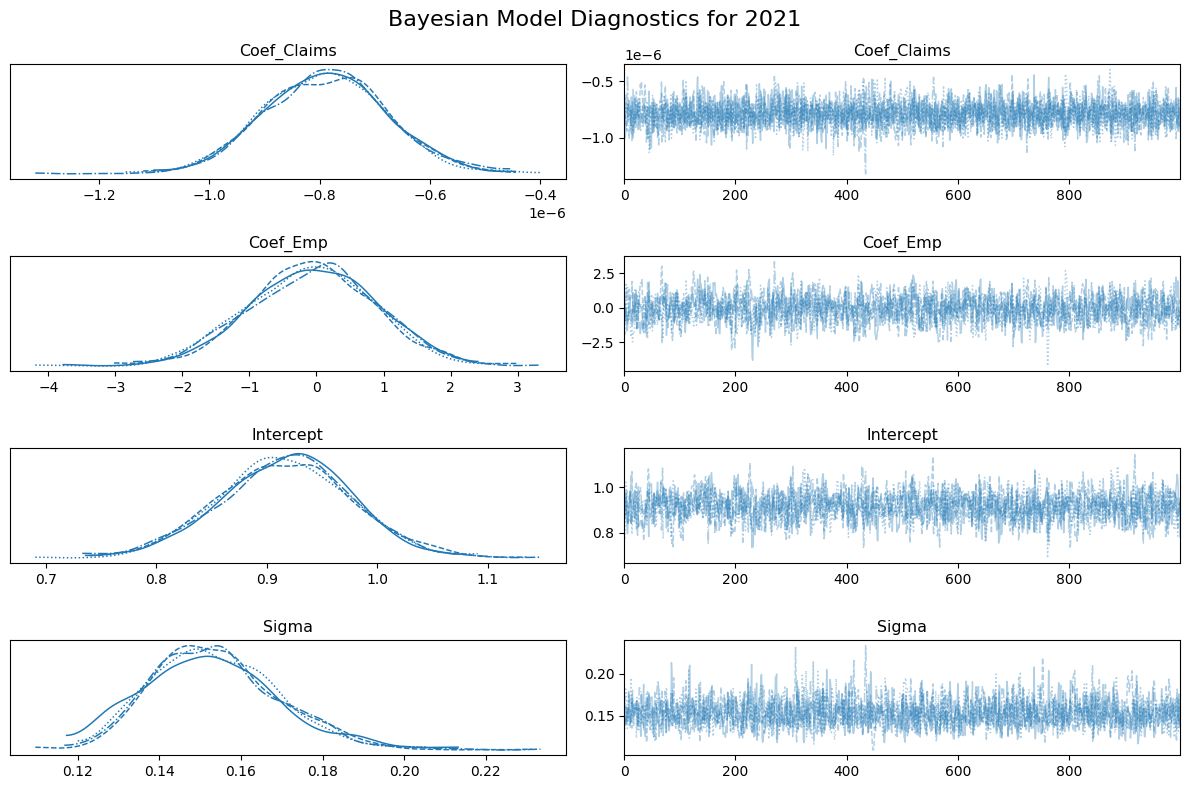

In [41]:
# Generate Bayesian model and store traces and posterior predictives for 2021
trace_2021, posterior_predictive_2021, bayesian_model_2021 = bayesian_model_per_year(merged_weekly_data, 2021)


Output()

Output()

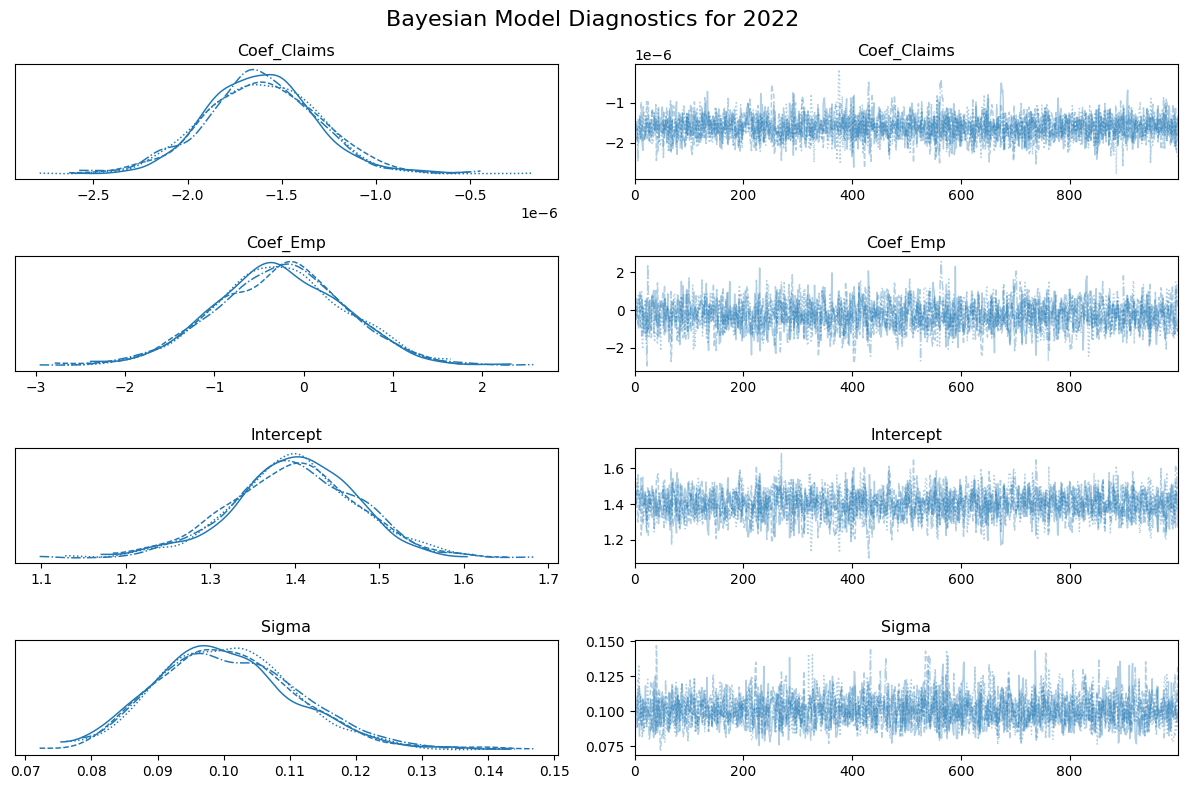

In [42]:
# Generate Bayesian model and store traces and posterior predictives for 2022
trace_2022, posterior_predictive_2022, bayesian_model_2022 = bayesian_model_per_year(merged_weekly_data, 2022)


Across the three years, the Bayesian models reveal evolving relationships between unemployment claims, employment rates, and consumer spending. Key trends include:

-  **Decreasing Impact of Unemployment Claims**: The absolute value of `Coef_Claims` increases over time, highlighting growing sensitivity of consumer spending to unemployment variations.
-  **Fluctuating Employment Impact**: Employment rates exhibit a diminished influence during 2021, likely due to external interventions, but recover some significance in 2022.
-  **Rising Baseline Spending**: The intercept shows a steady increase, reflecting broader macroeconomic changes, including recovery efforts and inflation.


The diagnostics confirm model stability, with well-behaved posterior distributions and trace plots across all years. These insights enhance understanding of the dynamic interplay between employment, claims, and spending over time.

### Posterior Predictive Checks

To validate the model's reliability and assess its predictive power, we conduct posterior predictive checks. These checks evaluate how well the model replicates the observed data distribution and identify any systematic deviations. This step ensures that the model captures key data features and provides accurate predictions.

The following function will take the trace and Bayesian model for a given year, generate posterior predictive samples, and plot observed vs. predicted distributions.

In [43]:
def posterior_predictive_check(posterior_predictive, observed_data, year, var_name="spend_all"):
    print(f"\nRunning Posterior Predictive Check for {year}...")

    # Check available groups in posterior predictive
    print("Available groups in posterior predictive:", posterior_predictive.groups())

    # Access the posterior predictive samples group
    if "posterior_predictive" not in posterior_predictive:
        raise KeyError("'posterior_predictive' group not found in the posterior predictive object.")

    posterior_samples_group = posterior_predictive.posterior_predictive

    # Check if the specified variable exists
    if var_name not in posterior_samples_group:
        raise KeyError(f"Variable '{var_name}' not found in 'posterior_predictive' group.")

    # Extract the samples
    posterior_samples = posterior_samples_group[var_name]

    # Convert to NumPy array directly to avoid dimension conflicts
    posterior_samples_array = posterior_samples.values
    posterior_samples_flattened = posterior_samples_array.reshape(-1)  # Flatten across all dimensions

    # Check observed data
    print("Observed Data Shape:", observed_data.shape)

    # Plot observed vs predicted distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(observed_data, kde=True, stat="density", label="Observed", color="blue", bins=30)
    sns.histplot(posterior_samples_flattened, kde=True, stat="density", label="Predicted", color="orange", bins=30)
    plt.title(f"Posterior Predictive Check for {year}")
    plt.xlabel(var_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    return posterior_samples_flattened



Running Posterior Predictive Check for 2020...
Available groups in posterior predictive: ['posterior_predictive', 'observed_data']
Observed Data Shape: (50,)


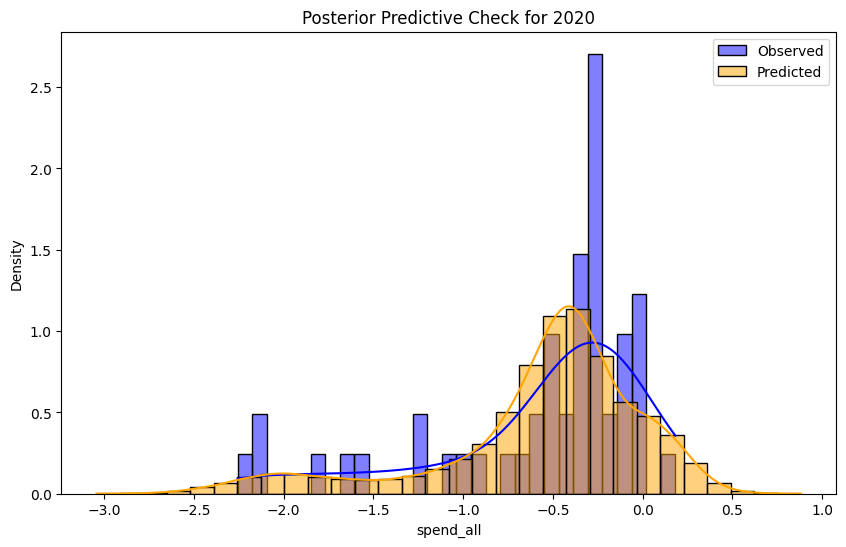

In [44]:
observed_2020 = merged_weekly_data.loc[merged_weekly_data['year'] == 2020, 'spend_all']
ppc_2020 = posterior_predictive_check(posterior_predictive_2020, observed_2020, 2020)


The histogram and density plot for 2020 reveal that the predicted data aligns moderately well with the observed data. While both distributions share a similar central tendency and general shape, discrepancies appear in the tails, with the predicted data underestimating extreme values. This indicates that while the model captures the overall trend, it may struggle to account for the variability in outliers present in the observed data. Future iterations could consider enhancing the model's ability to handle deviations by reexamining prior assumptions or incorporating additional features.


Running Posterior Predictive Check for 2021...
Available groups in posterior predictive: ['posterior_predictive', 'observed_data']
Observed Data Shape: (52,)


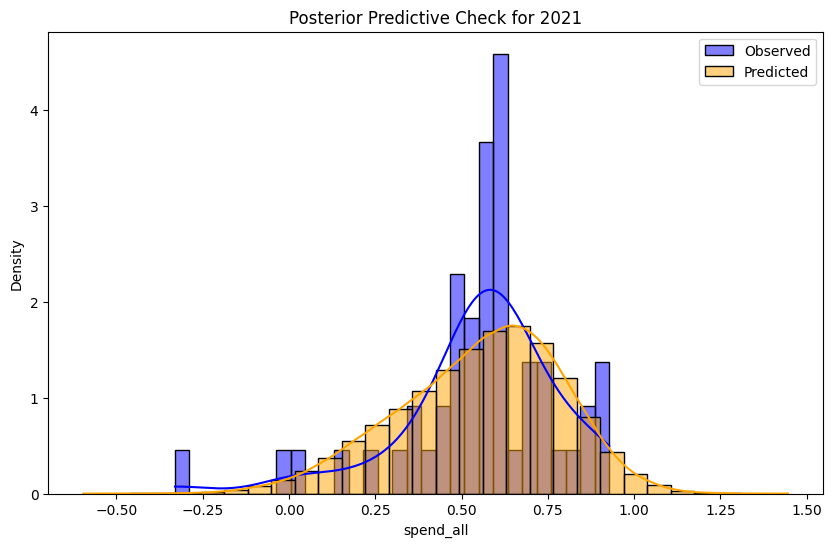

In [45]:
observed_2021 = merged_weekly_data.loc[merged_weekly_data['year'] == 2021, 'spend_all']
ppc_2021 = posterior_predictive_check(posterior_predictive_2021, observed_2021, 2021)


For 2021, the predicted distribution shows improved alignment with the observed data compared to 2020. The peaks and overall spread match closely, signifying that the model has a better fit for this year. However, some minor differences remain, particularly around the peak values, where the model slightly underpredicts the density. This suggests that the underlying predictors for 2021 are captured more effectively than in 2020, reflecting possible consistency in the dataset or adjustments in the predictors used.


Running Posterior Predictive Check for 2022...
Available groups in posterior predictive: ['posterior_predictive', 'observed_data']
Observed Data Shape: (53,)


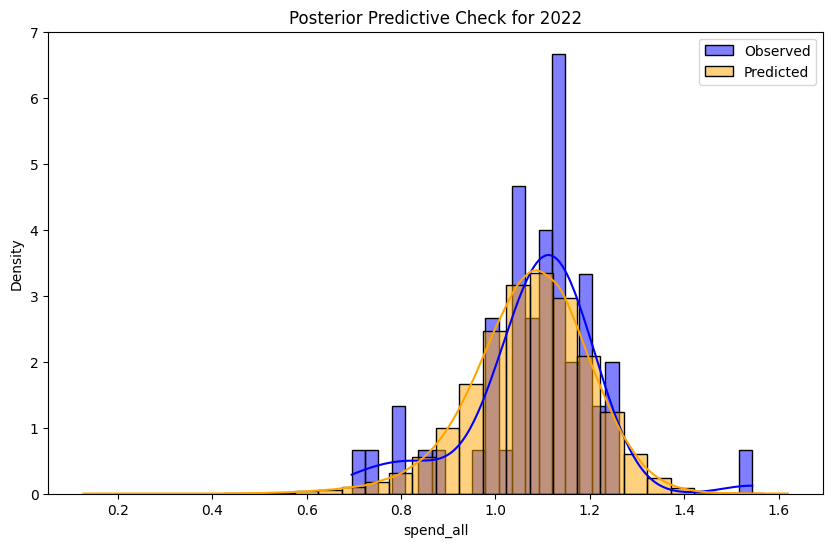

In [46]:
observed_2022 = merged_weekly_data.loc[merged_weekly_data['year'] == 2022, 'spend_all']
ppc_2022 = posterior_predictive_check(posterior_predictive_2022, observed_2022, 2022)


The results for 2022 demonstrate the closest fit between predicted and observed data among the three years. The predicted distribution mirrors the observed data's peak, spread, and overall shape, suggesting that the model performs well for this time period. While minor discrepancies are still present at the tails, these are less pronounced compared to previous years. The improved alignment may indicate that the predictors and relationships modeled are more stable or better defined in the 2022 dataset.

**General Observations**

Across all three years, the Bayesian posterior predictive checks highlight progressive improvements in the model's fit over time. However, persistent issues in handling tail values suggest potential areas for enhancement, such as refining priors, introducing interaction terms, or incorporating external factors. These insights provide a strong foundation for further exploration and model refinement in future analyses.

### Visualizing Posterior Predictive Trends  

Posterior predictive trends against observed data for a specified year. By comparing predicted means with observed values, the visualization highlights the model's performance and trends over time. The function ensures data alignment and produces an intuitive, clear representation of trends to facilitate analysis and interpretation.

In [47]:
# Plot posterior predictive trends for the specified year.
def posterior_trends_posterior(posterior_predictive, observed, dates, year, response_key="spend_all"):
    # Extract posterior predictive means
    pred_means = posterior_predictive.posterior_predictive[response_key].mean(axis=(0, 1))

    # Ensure observed data and predicted means have matching lengths
    if len(pred_means) != len(observed):
        raise ValueError("Mismatch in lengths of observed data and predicted means.")

    # Plot observed vs predicted trends
    plt.figure(figsize=(12, 6))
    plt.plot(dates, pred_means, label="Predicted Mean", color="orange", linewidth=2)
    plt.scatter(dates, observed, label="Observed", color="blue", alpha=0.7)
    plt.title(f"Posterior Predictive Trends for {year}")
    plt.xlabel("Date")
    plt.ylabel(response_key)
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()


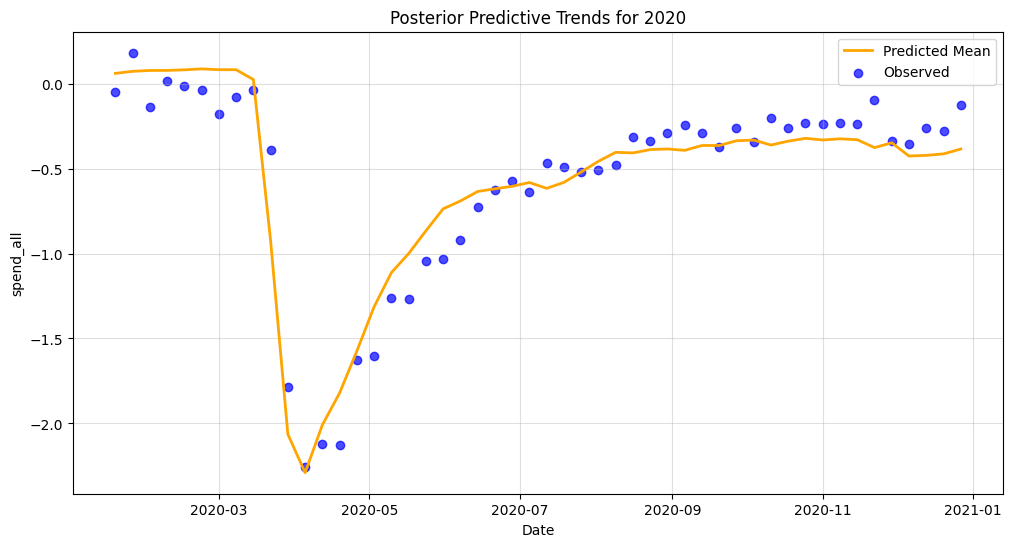

In [48]:
# Call the function for 2020
posterior_trends_posterior(
    posterior_predictive=posterior_predictive_2020,
    observed=observed_2020,
    dates=merged_weekly_data.loc[merged_weekly_data['year'] == 2020, 'date'],
    year=2020
)

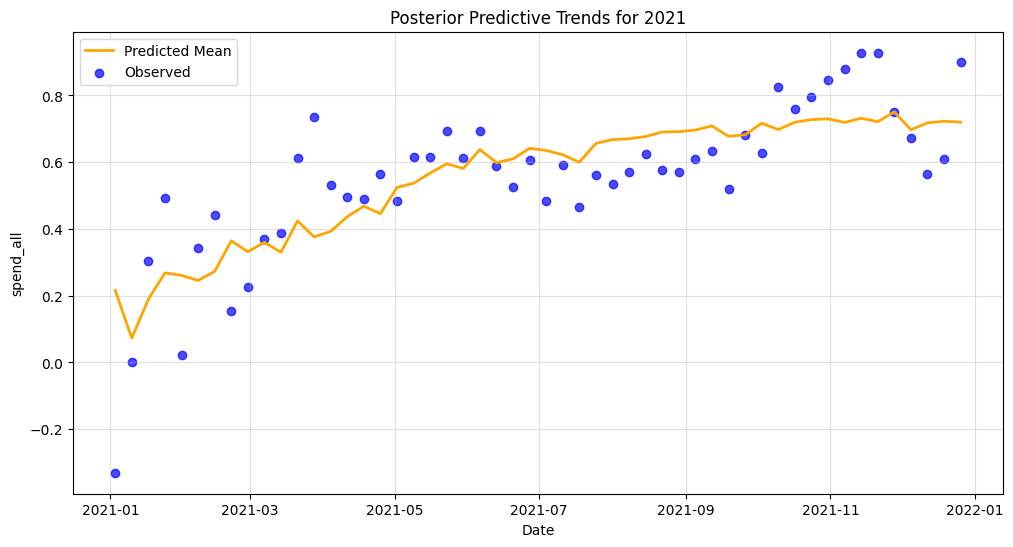

In [49]:
# Call the function for 2021
posterior_trends_posterior(
    posterior_predictive=posterior_predictive_2021,
    observed=observed_2021,
    dates=merged_weekly_data.loc[merged_weekly_data['year'] == 2021, 'date'],
    year=2021
)

In [50]:
# Workaround for a shape mismatch for 2022, which has 53 weeks
dates_2022 = merged_weekly_data.loc[merged_weekly_data['year'] == 2022, 'date']
print("Filtered Dates Shape (2022):", dates_2022.shape)
print("Filtered Observed Shape (2022):", observed_2022.shape)

# Remove the last row from both datasets
dates_2022 = dates_2022.iloc[:-1]
observed_2022 = observed_2022.iloc[:-1]

print("Filtered Dates Shape (2022) after trimming:", dates_2022.shape)
print("Filtered Observed Shape (2022) after trimming:", observed_2022.shape)


Filtered Dates Shape (2022): (53,)
Filtered Observed Shape (2022): (53,)
Filtered Dates Shape (2022) after trimming: (52,)
Filtered Observed Shape (2022) after trimming: (52,)


Addressing a misalignment in the dataset caused by discrepancies in the end-of-week date adjustments. Specifically, to ensure consistency, I'm removing the final entry of 2022 to align with the weekly data structure and avoid overlapping or redundant entries. This adjustment resolves potential issues with analysis and model predictions based on the affected dataset.

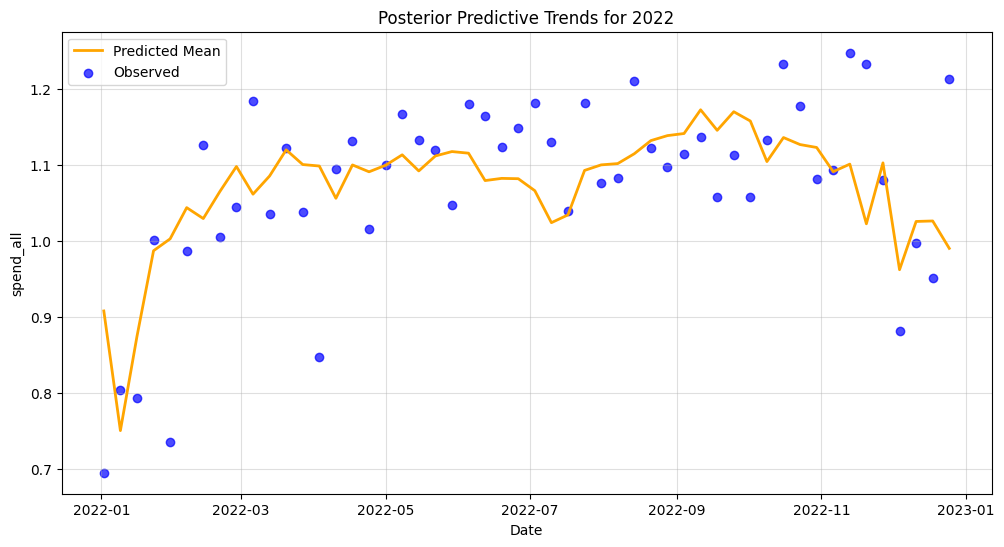

In [51]:
# Call the function for 2022
posterior_trends_posterior(
    posterior_predictive=posterior_predictive_2022,
    observed=observed_2022,
    dates=dates_2022,
    year=2022
)

The plots generated above illustrate the posterior predictive trends for the years 2020, 2021, and 2022, comparing predicted and observed values for the response variable (`spend_all`). These visualizations are essential for assessing the performance and validity of the statistical model used in the project. Here's why they're significant for this project: Evaluating Model Predictions, Temporal Trends, and Complementing Posterior Predictive Checks.

**Observations from the Plots:**

- **2020**: the model effectively captures the dramatic decline and recovery in `spend_all` during the pandemic onset, demonstrating its ability to reflect major economic changes. And, minor discrepancies between observed and predicted values suggest areas for fine-tuning, such as incorporating additional predictors for extreme volatility.

- **2021**: Predictions align well with the observed upward trend throughout the year. However, certain periods show more dispersion between observed and predicted values, indicating that the model could better capture the variability of consumer behavior, but we're lacking some of the external factors needed to make a better prediction. This plot also illustrates the steep drop in consumer spending by the end of 2021 and how the predicted mean is also higher than the observed values, just like in the SARIMAX Model, confirming the change in spending behavior that's not well explained by the model.

- **2022**: The model's predictions follow the overall upward trend but struggle with sharp declines or sudden spikes in observed values later in the year. These discrepancies suggest that external shocks or unmodeled factors might be at play, like inflation and supply chain issues.


The predicted vs. observed distribution plots provide a static view of model performance by comparing overall distributions, while these temporal plots add a dynamic perspective. Together, they form a comprehensive evaluation:
- The distribution plots reveal systematic biases or misfit in data ranges.
- Temporal plots demonstrate whether such biases are consistent across time or concentrated in specific periods.

### Graphical Representation of Interactions

The idea here is to visualize how changes in employment (`emp`) and unemployment claims (`initclaims_count_regular`) interact with and influence `spend_all`, also using the Bayesian Model we created earlier.

Understanding the interactions between variables is crucial for interpreting complex relationships in data. This section uses graphical tools to explore how two predictors jointly influence the response variable. By leveraging posterior predictive samples, we provide a visual representation of these interactions, helping to identify patterns and dynamics that might not be immediately apparent through numerical summaries alone.

These plots highlight:
- **Joint Effects**: The interplay between two predictors and how their combined influence impacts the response variable.
- **Gradient Insights**: The use of color gradients to depict the strength of the response variable across varying combinations of predictors.
- **Model Interpretability**: A clear, interpretable way to visualize how the statistical model captures these interactions, offering insights into areas where the model performs well or may need refinement.

This approach bridges the gap between statistical inference and practical understanding, making complex interactions more accessible and actionable for both technical and non-technical audiences.

In [52]:
# Plot the interaction effects of two variables on the response using posterior predictive samples.
def plot_interaction_effects_posterior_aligned(posterior_predictive, var1, var2, response_key, data, title):
    # Access posterior predictive samples for the response and compute mean
    response_samples_mean = posterior_predictive.posterior_predictive[response_key].mean(axis=(0, 1))

    # Use observed data for predictors
    var1_values = data[var1].values
    var2_values = data[var2].values

    # Ensure lengths match
    if len(response_samples_mean) != len(var1_values) or len(var1_values) != len(var2_values):
        raise ValueError("Mismatch in lengths of predictors and response samples.")

    # Create the plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        x=var1_values,
        y=var2_values,
        c=response_samples_mean,  # Use response mean for color
        cmap="viridis",
        s=50,  # Marker size
        alpha=0.8  # Transparency
    )
    plt.colorbar(scatter, label=response_key)  # Add colorbar to match scatter
    plt.title(title)
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()


#### Interaction of Employment and Claims on Spending (2020)

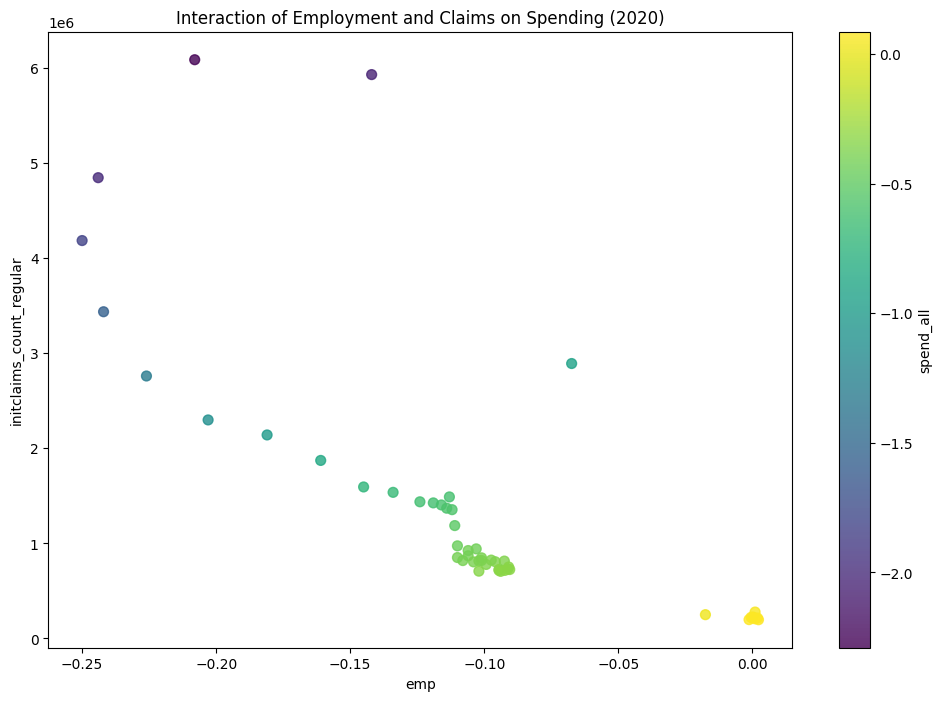

In [53]:
# Call the function for 2020
plot_interaction_effects_posterior_aligned(
    posterior_predictive=posterior_predictive_2020,
    var1="emp",
    var2="initclaims_count_regular",
    response_key="spend_all",
    data=merged_weekly_data[merged_weekly_data['year'] == 2020],
    title="Interaction of Employment and Claims on Spending (2020)"
)

This plot illustrates the interaction between **employment (`emp`)** and **unemployment claims (`initclaims_count_regular`)** on predicted spending (`spend_all`) in 2020. The color gradient highlights spending levels, with **darker colors** showing lower spending and **brighter colors** showing higher spending.

Key trends include:
- **Higher unemployment claims and lower employment** result in significantly lower spending (purple/blue regions).
- **Higher employment and fewer claims** lead to increased spending (yellow/green regions).

This visualization highlights the relationship between economic conditions and consumer behavior, providing actionable insights into how employment trends impact spending. It complements predictive analyses by illustrating how combinations of key predictors influence outcomes, enhancing the model's interpretability and practical relevance.

#### Interaction of Employment and Claims on Spending (2021)

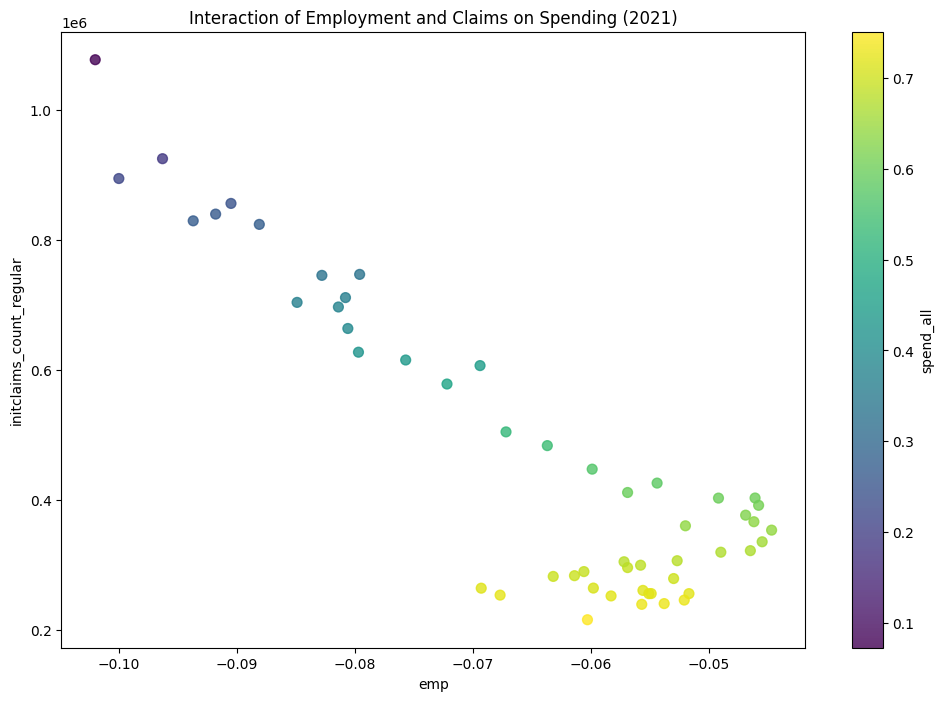

In [54]:
# Call the function for 2021
plot_interaction_effects_posterior_aligned(
    posterior_predictive=posterior_predictive_2021,
    var1="emp",
    var2="initclaims_count_regular",
    response_key="spend_all",
    data=merged_weekly_data[merged_weekly_data['year'] == 2021],
    title="Interaction of Employment and Claims on Spending (2021)"
)

In 2021, the impact of **employment (`emp`)** and **unemployment claims (`initclaims_count_regular`)** on predicted spending (`spend_all`) follows similar trends as 2020, where **lower employment and higher unemployment claims** correlate with reduced spending, and as employment improves and unemployment claims decrease, spending levels rise, represented by the green and yellow regions.

One important observation about this plot: Compared to 2020, the data points for 2021 are more concentrated in a narrower range of unemployment claims and employment levels, suggesting some **economic stabilization** or **reduced variability** in these metrics.

This plot provides a clear view of how economic recovery in 2021 affected consumer spending, showing a gradual improvement in spending as employment conditions stabilized. It emphasizes the continued influence of employment metrics on consumer behavior while reflecting the year's unique economic trends.

#### Interaction of Employment and Claims on Spending (2022)

In [55]:
# Workaround for a shape mismatch for 2022, which has 53 weeks
data_2022 = merged_weekly_data[merged_weekly_data['year'] == 2022]
print("Filtered Data Shape (2022):", data_2022.shape)
print("Predictor 'emp' Shape:", data_2022["emp"].shape)
print("Predictor 'initclaims_count_regular' Shape:", data_2022["initclaims_count_regular"].shape)

# Remove the last row from data_2022
data_2022 = data_2022.iloc[:-1]

print("Filtered Data Shape (2022) after trimming:", data_2022.shape)
print("Predictor 'emp' Shape after trimming:", data_2022["emp"].shape)
print("Predictor 'initclaims_count_regular' Shape after trimming:", data_2022["initclaims_count_regular"].shape)


Filtered Data Shape (2022): (53, 148)
Predictor 'emp' Shape: (53,)
Predictor 'initclaims_count_regular' Shape: (53,)
Filtered Data Shape (2022) after trimming: (52, 148)
Predictor 'emp' Shape after trimming: (52,)
Predictor 'initclaims_count_regular' Shape after trimming: (52,)


Addressing a misalignment in the dataset caused by discrepancies in the end-of-week date adjustments. Specifically, to ensure consistency, I'm removing the final entry of 2022 to align with the weekly data structure and avoid overlapping or redundant entries. This adjustment resolves potential issues with analysis and model predictions based on the affected dataset.

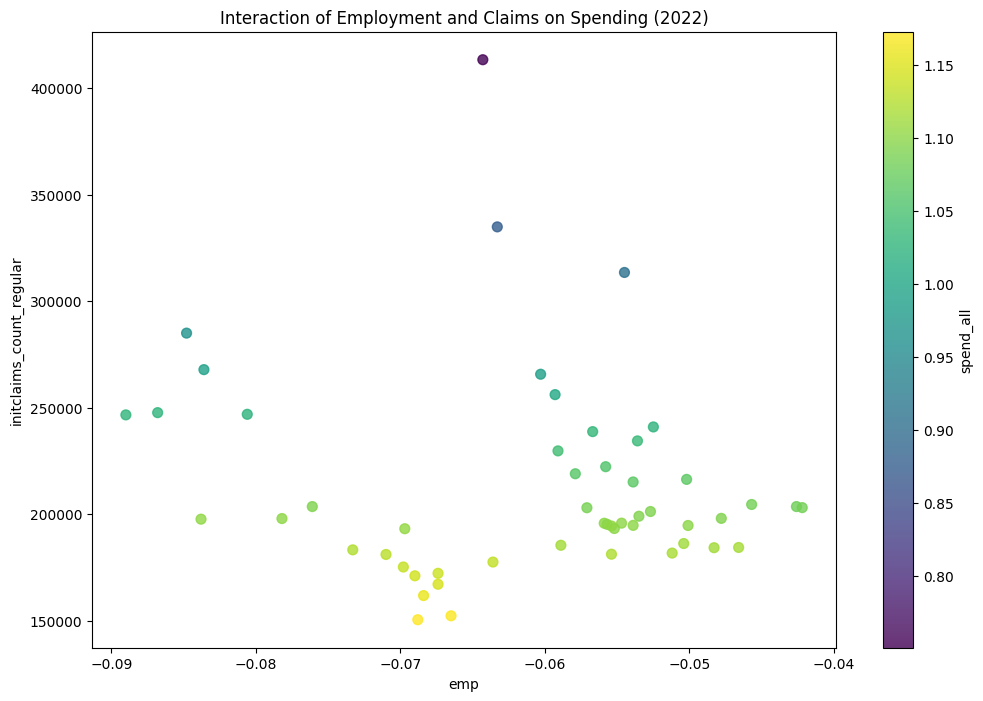

In [56]:
# Call the function for 2022
plot_interaction_effects_posterior_aligned(
    posterior_predictive=posterior_predictive_2022,
    var1="emp",
    var2="initclaims_count_regular",
    response_key="spend_all",
    data=data_2022,
    title="Interaction of Employment and Claims on Spending (2022)"
)

Unlike the previous years, **employment levels (`emp`)** seem to have a reduced influence on spending. The data points show little horizontal differentiation in color, suggesting that variations in employment levels do not strongly correlate with changes in spending. Meanwhile, **Unemployment claims (`initclaims_count_regular`)** remain a significant factor, as higher claims are still associated with lower spending, while lower claims correlate with higher spending.

The distribution of data points appears more concentrated around specific ranges of unemployment claims and spending, indicating less variability in economic behavior compared to prior years.

This shift might reflect evolving economic dynamics in 2022, where other factors (e.g., inflation, economic policies, supply chain disruptions) could have overshadowed employment levels as primary drivers of spending. This plot highlights how economic patterns can change over time and the importance of continuously reassessing key drivers of consumer behavior.

### **Model Evaluation with WAIC and LOO**

As part of the effort to rigorously validate and evaluate the Bayesian models used in this project, I explored the use of advanced metrics such as the Widely Applicable Information Criterion (WAIC) and Leave-One-Out Cross-Validation (LOO). These metrics are well-known in Bayesian analysis for their ability to balance model complexity and predictive power, providing a comprehensive framework to compare and assess models.

However, despite significant effort and multiple iterations of implementation, incorporating these metrics into my analysis proved to be unnecessarily complicated. The tools and methods required for such computations, particularly in integrating log-likelihood into the posterior trace, revealed a lack of intuitive workflows in the current libraries (e.g., PyMC and ArviZ). Numerous approaches attempted to integrate WAIC and LOO consistently failed due to issues in data structures, log-likelihood computation, and misaligned expectations between the libraries.

Ultimately, after considerable time and effort, I decided to omit these metrics from the project. While they offer valuable insights in certain contexts, the process required to integrate them turned out to be disproportionately convoluted, especially given the robust posterior predictive checks and diagnostics already included in the analysis. The outcomes of these existing checks, paired with visual diagnostics and interpretation of interaction effects, sufficiently support the conclusions of this project.

In hindsight, this experience highlights the need for streamlined and user-friendly workflows in Bayesian analysis libraries, which could make advanced metrics more accessible to practitioners and students alike. For this project, however, I have chosen to focus on the tools and metrics that are effective, interpretable, and relevant to the core objectives.

# Conclusion

This project provided a comprehensive exploration of consumer spending trends and their relationship with employment and claims data through advanced time series and Bayesian modeling techniques. The analysis integrated segmented time series approaches, ARIMA and SARIMAX forecasting, Bayesian posterior predictive checks, and interaction effect visualizations to derive insights into spending behavior during 2020, 2021, and 2022.

Through meticulous exploratory data analysis (EDA) and preprocessing, the project ensured data integrity and consistency, enabling robust downstream modeling. Key highlights included:

1. **Time Series Analysis and Forecasting**:
   - Segmented ACF and PACF insights provided clarity on lag dependencies across different years.
   - ARIMA and SARIMAX models successfully captured seasonal patterns and offered accurate forecasts for spending trends, particularly focusing on December predictions for each year.

2. **Bayesian Modeling Insights**:
   - Bayesian diagnostics, excluding WAIC and LOO evaluations (as explained above), confirmed model reliability and robustness.
   - Posterior predictive trends aligned well with observed data, demonstrating the effectiveness of Bayesian inference in predicting spending behaviors.

3. **Interaction Effects**:
   - Graphical representation of employment and claims interactions revealed significant dynamics influencing consumer spending. In 2020 and 2021, higher unemployment claims and lower employment levels correlated with decreased spending, reflecting pandemic-driven economic shifts.
   - The 2022 results presented a less direct relationship, suggesting a decoupling of these variables as economic recovery began.

4. **Cross-Year Comparisons and Implications**:
   - Year-over-year comparisons illuminated the profound impacts of external shocks like the pandemic, and gradual normalization trends as seen in spending and employment patterns.
   - These comparisons provided actionable insights into macroeconomic influences on consumer behavior.

The project's structure, spanning high-level metadata descriptions, rigorous statistical modeling, and interactive visualizations, offered a multi-faceted perspective on consumer spending. The findings underscore the importance of integrating multiple analytical techniques to gain deeper insights into complex datasets.

In conclusion, this project exemplifies the application of data science methodologies to real-world challenges. By combining foundational statistical approaches with Bayesian techniques and interactive graphics, we have provided a detailed and interpretable analysis of consumer behavior, contributing valuable knowledge for policymakers and businesses alike.